# BigTable MTLM, Summative
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [1]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, ones, floor, ceil
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten, maximum
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

from evaluate import calc_arr_arr_err
from classes import WeightClip, BigTable
from classes import Question, Student

n_traits = 2
user_patience = 10

random.seed(666)
numpy.random.seed(666)


Using TensorFlow backend.


In [2]:
generate_student_name()

'PHUTHY CORE '

In [3]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)
pr_k_mid = mid**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 0
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print(beta_min, beta_max)
print(theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**n_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
0 3.7440036742649454
1.5467790969287263 5.290782771193672
null-task passrate 0.5
all-null passrate 0.25
worst cmp chance= 0.10000000000000002
best cmp chance= 0.99498743710662
worst Pr= 0.010000000000000004
best Pr= 0.99
limits 0.8244480464246379 0.8244480464246379
[[1 2 3]
 [7 8 9]]
(2, 3)


In [4]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
#         if b == 0:
#             p_pass_step = 1
#         else:
#             if th==0:
#                 print("STUMPED")
#                 p_pass = 0
#                 return p_pass
#             else:
        z = (th-b)
        p_pass_step = exp(z) / (1.0 + exp(z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass

In [5]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [6]:
def create_qs(n_qs, nt=n_traits, nnw=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    
    mags = []
    for q in master_qs:
        comps = [c for c in q.betas]
        mag = sqrt(sum([ pow(c, 2) for c in comps ]))
#         print("{}, skill={:.2f}".format(psi.name, mag))
        mags.append(mag)
    ax[0].hist(mags)
    
    itemz = array([ q.betas for q in master_qs ])
#     fig.set_size_inches(10, 10)
    ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
    for i, txt in enumerate(itemz):
        ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
    plt.show()
        
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [7]:
def create_students(n_students, nt=n_traits, nnw=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    for psi in psi_list[0:20]:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
    
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    
    mags = []
    for psi in psi_list:
        comps = [c for c in psi.thetas]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
#         print("{}, skill={:.2f}".format(psi.name, mag))
        mags.append(mag)
    ax[0].hist(mags)
    
    itemz = array([ s.thetas for s in psi_list ])
#     fig.set_size_inches(10, 10)
    ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
    for i, txt in enumerate(itemz):
        ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
    plt.show()
        
    return psi_list, psi_table
    

In [8]:
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
#     user_patience = 10 #math.inf
    pass_to_remove = True
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                pp,passed = attempt_q(psi, q)
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)

                print("p_pass was",pp) #, "run p:", 1-(1-pp)**max_atts)

                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                qs.remove(qix)
                print("len qs is", len(qs))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [9]:
def generate_qs_model(qn_table, psi_table, optimiser, user_patience=user_patience):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     did_pass = Input(shape=(1,), name="did_pass")
#     did_n = Input(shape=(1,), name="did_n")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: K.exp(z) / (1.0 + K.exp(z)), name="sPr_sigmoid")(dif)
    
    print("Prs",Prs.shape)
    #calculate the hazard rate here
    hz = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    #pazz = Lambda( lambda p : (1.0-K.pow((1-p),user_patience)), name="pazz_calc" ) (hz)

#     print("hz",hz.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=[hz,])
    model.compile(optimizer=optimiser, loss=["binary_crossentropy"], metrics=["accuracy"])#, loss_weights=[1.0,1.0])
    return model

In [10]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    numpy.random.seed(666)
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        av_th = (min_th + max_th)/2.0
#         psi_wgts[s.id,:] = numpy.random.uniform(max_th-1, max_th, size=psi_wgts.shape[1])
        psi_wgts[s.id,:] = numpy.random.uniform(min_th, max_th, size=psi_wgts.shape[1])

        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        av_b = (min_b + max_b)/2.0
#         qn_wgts[q.id,:]= numpy.random.uniform(min_b, min_b+1, size=qn_wgts.shape[1])
        qn_wgts[q.id,:]= numpy.random.uniform(min_b, max_b, size=qn_wgts.shape[1])

        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [11]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    ns = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs
    nz = ns

#     for pf in pfs:
#         print(pf)
    
    print(qz)
    print(sz)
    print(pfz)
    print(nz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):

        base_ix = 0
        done = False
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=[pfz,])#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            topn=20
            predz = qs_model.predict(x=[qices[0:topn], psices[0:topn]], verbose=0) 
            for j in range(topn):
                print(qices[j], psices[j], pfs[j], ":", predz[j])

            tup = qs_model.evaluate(x=[qices, psices], y=[pfz,], verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            xhloss, acc = tup
            tup = xhloss, acc, 0,0
            sub_h.append(tup)

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.mean( numpy.abs(s_thetas - s_wgts) )
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.mean( numpy.abs(q_betas - q_wgts) )
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
#             print(loss,pf_loss,mse,acc, n_acc)
            print(mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2],sub_h[-1,3])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
            av_rmse =(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_summative.hdf5")
                print("...model saved")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break

    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


qid 0 [0.791230679511594, 0.3842011099362013]
qid 1 [3.5622620885877145, 2.725103240680137]
qid 2 [0.9148205346950475, 0.972974990761038]
qid 3 [1.9022021155618896, 0.37413290075062544]
qid 4 [3.0699203636421872, 2.8718912275506145]
qid 5 [1.0978471057721624, 2.623965327198739]
qid 6 [2.7390964154748265, 2.7503820604464613]
qid 7 [0.9272707582328841, 0.41541095559418784]
qid 8 [3.1740988242479924, 1.0894070707057917]
qid 9 [3.403971736158123, 0.7394525432143099]
qid 10 [1.9632829431436591, 3.528869343226305]
qid 11 [1.21938700125718, 2.1857965899641827]
qid 12 [1.4607701548570753, 1.1824137159143]
qid 13 [1.5601712813259134, 2.04926326496846]
qid 14 [1.9509897986447915, 3.2680641963900334]
qid 15 [0.8214690173613358, 2.9023253595892866]
qid 16 [2.38185914042834, 0.0038795108609379295]
qid 17 [3.101776502897618, 0.7164846214986826]
qid 18 [1.5096914801119135, 1.2525539744646907]
qid 19 [3.1890986812570583, 1.5653003965786114]
qid 20 [2.96238763990677, 1.6640633017034758]
qid 21 [3.34527

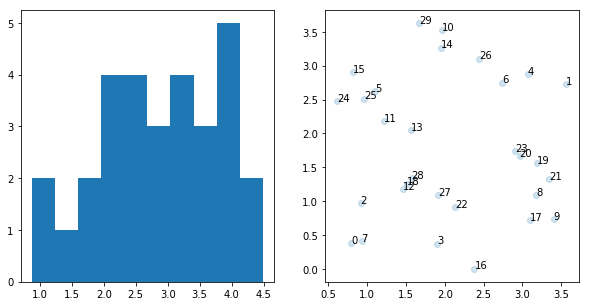

W0828 17:29:52.907780 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



PHUTHY CORE  [2.3380097764403205, 1.9309802068649276]
KIF YUN  [5.109041185516441, 4.271882337608863]
TIWEB CACER  [2.461599631623774, 2.519754087689764]
RONI PHIPA  [3.448981212490616, 1.9209119976793518]
THOSI ROGEN  [4.6166994605709135, 4.418670324479341]
GUR HOTHU  [2.6446262027008887, 4.170744424127465]
LASAPH LICI  [4.285875512403553, 4.297161157375188]
PHIRO SYDOP  [2.4740498551616104, 1.9621900525229141]
MIWYPH GEL  [4.720877921176719, 2.636186167634518]
FOK SIWI  [4.9507508330868495, 2.2862316401430363]
NIBI WON  [3.5100620400723854, 5.075648440155032]
LUR BIH  [2.766166098185906, 3.732575686892909]
NAS CHORAPH  [3.0075492517858016, 2.729192812843026]
SIN JAVIP  [3.1069503782546395, 3.596042361897186]
THAFY JITO  [3.4977688955735178, 4.814843293318759]
VYHAV TYNY  [2.368248114290062, 4.449104456518013]
PHAPHYT PUKOY  [3.9286382373570663, 1.5506586077896642]
NOPHI MEG  [4.648555599826344, 2.263263718427409]
CHISY FEN  [3.0564705770406397, 2.7993330713934172]
DATHU BAG  [4.73587

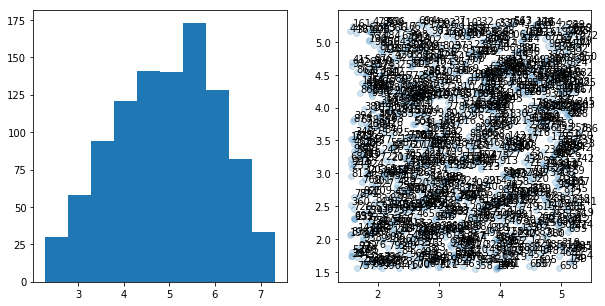

----0

p_pass was 0.5015360282991438
len qs is 29
p_pass was 0.1975302609707184
len qs is 28
p_pass was 0.4047716583844138
len qs is 27
p_pass was 0.11220934457985937
len qs is 26
p_pass was 0.4383731434377224
len qs is 25
p_pass was 0.4268962784943096
len qs is 24
p_pass was 0.31172285853002296
len qs is 23
p_pass was 0.12387159074850702
len qs is 22
p_pass was 0.5823969724155453
len qs is 21
p_pass was 0.2112874707642565
len qs is 20
p_pass was 0.17311607948330382
len qs is 19
p_pass was 0.6590912703081828
len qs is 18
p_pass was 0.12267783795322541
len qs is 17
p_pass was 0.24507587382946755
len qs is 16
p_pass was 0.07072031082131328
len qs is 15
p_pass was 0.46171708729930944
len qs is 14
p_pass was 0.17665471334363433
len qs is 13
p_pass was 0.22519005535409875
len qs is 12
p_pass was 0.196487375545832
len qs is 11
p_pass was 0.09116982405003364
len qs is 10
p_pass was 0.32910882877484804
len qs is 9
p_pass was 0.1022604416007448
len qs is 8
p_pass was 0.09972096750844545
len qs 

p_pass was 0.44018053266802476
len qs is 9
p_pass was 0.21604646250087922
len qs is 8
p_pass was 0.5454086901784316
len qs is 7
p_pass was 0.266395056908193
len qs is 6
p_pass was 0.6904373734202586
len qs is 5
p_pass was 0.26112192910232385
len qs is 4
p_pass was 0.6797145812534019
len qs is 3
p_pass was 0.8320300098011273
len qs is 2
p_pass was 0.5359986302181369
len qs is 1
p_pass was 0.4975143944018061
len qs is 0
p_pass was 0.7341306211549322
len qs is 29
p_pass was 0.6588150588253879
len qs is 28
p_pass was 0.6797145812534018
len qs is 27
p_pass was 0.6813594814725858
len qs is 26
p_pass was 0.8278251289163686
len qs is 25
p_pass was 0.5792074680162859
len qs is 24
p_pass was 0.686596646009331
len qs is 23
p_pass was 0.5342655846831376
len qs is 22
p_pass was 0.7038124974609399
len qs is 21
p_pass was 0.46606182296409177
len qs is 20
p_pass was 0.6611547803423616
len qs is 19
p_pass was 0.8797011015025059
len qs is 18
p_pass was 0.8841611494713066
len qs is 17
p_pass was 0.919255

len qs is 2
p_pass was 0.13386265249609536
len qs is 1
p_pass was 0.15824642481649012
len qs is 0
p_pass was 0.9240921677442558
len qs is 29
p_pass was 0.9497549501289096
len qs is 28
p_pass was 0.969002779779848
len qs is 27
p_pass was 0.9130333437323147
len qs is 26
p_pass was 0.7755898489947269
len qs is 25
p_pass was 0.940588717328646
len qs is 24
p_pass was 0.8331286071225861
len qs is 23
p_pass was 0.8145042584513198
len qs is 22
p_pass was 0.849990213290085
len qs is 21
p_pass was 0.9785195222921516
len qs is 20
p_pass was 0.9416399146627845
len qs is 19
p_pass was 0.8964043622685286
len qs is 18
p_pass was 0.8784733180611928
len qs is 17
p_pass was 0.8845642434221856
len qs is 16
p_pass was 0.9534234434599402
len qs is 15
p_pass was 0.8124911559160676
len qs is 14
p_pass was 0.9766030564345842
len qs is 13
p_pass was 0.8721273540862542
len qs is 12
p_pass was 0.8597777539419561
len qs is 11
p_pass was 0.7668043420292602
len qs is 10
p_pass was 0.7993608889304653
len qs is 9
p_p

len qs is 12
p_pass was 0.9111899870495693
len qs is 11
p_pass was 0.7738979592666756
len qs is 10
p_pass was 0.9659304341554652
len qs is 9
p_pass was 0.7668671514947206
len qs is 8
p_pass was 0.9243376287287746
len qs is 7
p_pass was 0.9293106653070943
len qs is 6
p_pass was 0.729735271671043
len qs is 5
p_pass was 0.7891217377505555
len qs is 4
p_pass was 0.7559405347837639
len qs is 3
p_pass was 0.9188273015199834
len qs is 2
p_pass was 0.6460680083425889
len qs is 1
p_pass was 0.7936283177218341
len qs is 0
p_pass was 0.6186324032829285
len qs is 29
p_pass was 0.5771661757310333
len qs is 28
p_pass was 0.18794752756558677
len qs is 27
p_pass was 0.17409248287670254
len qs is 26
p_pass was 0.41749650053260556
len qs is 25
p_pass was 0.4166834970926117
len qs is 24
p_pass was 0.5792210584986255
len qs is 23
p_pass was 0.6178212330884558
len qs is 22
p_pass was 0.7847237236604552
len qs is 21
p_pass was 0.32199033203129956
len qs is 20
p_pass was 0.4242311428929104
len qs is 19
p_pas

len qs is 11
p_pass was 0.7437789218958438
len qs is 10
p_pass was 0.547122006167103
len qs is 9
p_pass was 0.34613104344571166
len qs is 8
p_pass was 0.6044935068942072
len qs is 7
p_pass was 0.7565404073273857
len qs is 6
p_pass was 0.2821572214524649
len qs is 5
p_pass was 0.552799889184639
len qs is 4
p_pass was 0.644721079820721
len qs is 3
p_pass was 0.8216900744227262
len qs is 2
p_pass was 0.8751186154750412
len qs is 1
p_pass was 0.27055675668880946
len qs is 0
p_pass was 0.6938622881033032
len qs is 29
p_pass was 0.8591512001642738
len qs is 28
p_pass was 0.6962044211981151
len qs is 27
p_pass was 0.7990062055036992
len qs is 26
p_pass was 0.948739485563881
len qs is 25
p_pass was 0.9080300102879534
len qs is 24
p_pass was 0.6355744210843144
len qs is 23
p_pass was 0.8680455792904698
len qs is 22
p_pass was 0.8263672086068027
len qs is 21
p_pass was 0.8818680577043655
len qs is 20
p_pass was 0.8645714822689877
len qs is 19
p_pass was 0.7397377189007127
len qs is 18
p_pass was

len qs is 1
p_pass was 0.552581157823749
len qs is 0
p_pass was 0.4162508497144135
len qs is 29
p_pass was 0.5979593262534684
len qs is 28
p_pass was 0.29370066486078605
len qs is 27
p_pass was 0.8732216388909746
len qs is 26
p_pass was 0.8400170216353133
len qs is 25
p_pass was 0.5362964053164544
len qs is 24
p_pass was 0.6730548812654985
len qs is 23
p_pass was 0.35076605775308717
len qs is 22
p_pass was 0.5095356764320137
len qs is 21
p_pass was 0.4530970641314
len qs is 20
p_pass was 0.4710771629935692
len qs is 19
p_pass was 0.40718370157380784
len qs is 18
p_pass was 0.5505500966578533
len qs is 17
p_pass was 0.8832930530073807
len qs is 16
p_pass was 0.7686875122462283
len qs is 15
p_pass was 0.7796479697761218
len qs is 14
p_pass was 0.5034605607543721
len qs is 13
p_pass was 0.7348118601768867
len qs is 12
p_pass was 0.6682773345948527
len qs is 11
p_pass was 0.35080050142632496
len qs is 10
p_pass was 0.514123705554221
len qs is 9
p_pass was 0.39390449158381735
len qs is 8
p_

p_pass was 0.5592223924944898
len qs is 9
p_pass was 0.9008199776965921
len qs is 8
p_pass was 0.9120472099393037
len qs is 7
p_pass was 0.8004506825158415
len qs is 6
p_pass was 0.5137878030506435
len qs is 5
p_pass was 0.8190668165410125
len qs is 4
p_pass was 0.5823942363452578
len qs is 3
p_pass was 0.5095669569626377
len qs is 2
p_pass was 0.7723745271473071
len qs is 1
p_pass was 0.5724295658342273
len qs is 0
p_pass was 0.8695923074464634
len qs is 29
p_pass was 0.6801034713861168
len qs is 28
p_pass was 0.6812546112798549
len qs is 27
p_pass was 0.8698999409352687
len qs is 26
p_pass was 0.7410933754284976
len qs is 25
p_pass was 0.9075369434207873
len qs is 24
p_pass was 0.7050673759299971
len qs is 23
p_pass was 0.7214225742940004
len qs is 22
p_pass was 0.901018591790912
len qs is 21
p_pass was 0.8228106383797608
len qs is 20
p_pass was 0.8847545808478728
len qs is 19
p_pass was 0.7232529111515941
len qs is 18
p_pass was 0.6819958935961151
len qs is 17
p_pass was 0.708963137

p_pass was 0.7459313721029827
len qs is 15
p_pass was 0.8903843567637492
len qs is 14
p_pass was 0.9219784127930434
len qs is 13
p_pass was 0.7177546093061797
len qs is 12
p_pass was 0.7943087503882055
len qs is 11
p_pass was 0.9606651721821549
len qs is 10
p_pass was 0.8755704022688237
len qs is 9
p_pass was 0.7220013811157359
len qs is 8
p_pass was 0.9307196486239743
len qs is 7
p_pass was 0.9147664907591335
len qs is 6
p_pass was 0.8911105916469135
len qs is 5
p_pass was 0.9646879493893514
len qs is 4
p_pass was 0.7872745713964178
len qs is 3
p_pass was 0.7651493271656913
len qs is 2
p_pass was 0.8767576847722782
len qs is 1
p_pass was 0.6361195343936487
len qs is 0
p_pass was 0.4457054945326574
len qs is 29
p_pass was 0.7800454058189947
len qs is 28
p_pass was 0.48175434796683453
len qs is 27
p_pass was 0.8845153201369551
len qs is 26
p_pass was 0.7894534849357855
len qs is 25
p_pass was 0.46929468042144556
len qs is 24
p_pass was 0.48010170169380073
len qs is 23
p_pass was 0.50597

len qs is 29
p_pass was 0.34876687278019447
len qs is 28
p_pass was 0.5970801277303749
len qs is 27
p_pass was 0.15100869089993557
len qs is 26
p_pass was 0.18719160263936777
len qs is 25
p_pass was 0.3372697369314123
len qs is 24
p_pass was 0.4714095171049535
len qs is 23
p_pass was 0.2261991545100974
len qs is 22
p_pass was 0.3126914289586846
len qs is 21
p_pass was 0.6736504705378382
len qs is 20
p_pass was 0.5664284072237683
len qs is 19
p_pass was 0.1409095260455289
len qs is 18
p_pass was 0.5064351615854442
len qs is 17
p_pass was 0.6353753815704202
len qs is 16
p_pass was 0.41053920707777203
len qs is 15
p_pass was 0.6255758986236399
len qs is 14
p_pass was 0.22794116653063828
len qs is 13
p_pass was 0.20525445806036738
len qs is 12
p_pass was 0.800478461530336
len qs is 11
p_pass was 0.6419194274203184
len qs is 10
p_pass was 0.25853714734936245
len qs is 9
p_pass was 0.6470193364625035
len qs is 8
p_pass was 0.6958969945659784
len qs is 7
p_pass was 0.6035068049784865
len qs i

p_pass was 0.08858385777951881
len qs is 8
p_pass was 0.46075028532305035
len qs is 7
p_pass was 0.07035824983608453
len qs is 6
p_pass was 0.22775171831860733
len qs is 5
p_pass was 0.22743496876721747
len qs is 4
p_pass was 0.20317201398647877
len qs is 3
p_pass was 0.2178123726505215
len qs is 2
p_pass was 0.11687399957092838
len qs is 1
p_pass was 0.20236750333791118
len qs is 0
p_pass was 0.43079445471793676
len qs is 29
p_pass was 0.2504029449822414
len qs is 28
p_pass was 0.5057353574901017
len qs is 27
p_pass was 0.7551731923214335
len qs is 26
p_pass was 0.6535902248748183
len qs is 25
p_pass was 0.4056564156294524
len qs is 24
p_pass was 0.20692846995226594
len qs is 23
p_pass was 0.830688369504016
len qs is 22
p_pass was 0.23766337767515627
len qs is 21
p_pass was 0.6577042726632385
len qs is 20
p_pass was 0.737004962828105
len qs is 19
p_pass was 0.6913792150173849
len qs is 18
p_pass was 0.5105862260590732
len qs is 17
p_pass was 0.40387800684730313
len qs is 16
p_pass was

len qs is 4
p_pass was 0.2007564954446246
len qs is 3
p_pass was 0.6056632455202382
len qs is 2
p_pass was 0.41238927222989624
len qs is 1
p_pass was 0.46236390440056435
len qs is 0
p_pass was 0.46061683771947176
len qs is 29
p_pass was 0.09852973300448607
len qs is 28
p_pass was 0.14902316518843894
len qs is 27
p_pass was 0.06201400050969643
len qs is 26
p_pass was 0.11574953671980624
len qs is 25
p_pass was 0.2266893834429409
len qs is 24
p_pass was 0.11404866210200158
len qs is 23
p_pass was 0.035573536712225975
len qs is 22
p_pass was 0.350659061863867
len qs is 21
p_pass was 0.5381110643589047
len qs is 20
p_pass was 0.047673000712105285
len qs is 19
p_pass was 0.20046968954212582
len qs is 18
p_pass was 0.11457773555599246
len qs is 17
p_pass was 0.2751177559145164
len qs is 16
p_pass was 0.0626432683995414
len qs is 15
p_pass was 0.21776389828205606
len qs is 14
p_pass was 0.2296381870356457
len qs is 13
p_pass was 0.17736573049280996
len qs is 12
p_pass was 0.3632515236067771
l

len qs is 15
p_pass was 0.8767127579328416
len qs is 14
p_pass was 0.5808433401235843
len qs is 13
p_pass was 0.9465674672243063
len qs is 12
p_pass was 0.7841873453024403
len qs is 11
p_pass was 0.5490149442562932
len qs is 10
p_pass was 0.6870921108270593
len qs is 9
p_pass was 0.5854793163038499
len qs is 8
p_pass was 0.9426791339826119
len qs is 7
p_pass was 0.8855733099394941
len qs is 6
p_pass was 0.7369560772979579
len qs is 5
p_pass was 0.757162258226862
len qs is 4
p_pass was 0.8837268160610795
len qs is 3
p_pass was 0.7274127480001965
len qs is 2
p_pass was 0.9195922604030822
len qs is 1
p_pass was 0.8019837159302221
len qs is 0
p_pass was 0.12272325578934337
len qs is 29
p_pass was 0.2407239706709414
len qs is 28
p_pass was 0.5601367218061709
len qs is 27
p_pass was 0.3885437697533332
len qs is 26
p_pass was 0.1270300741551584
len qs is 25
p_pass was 0.554452938260825
len qs is 24
p_pass was 0.28706532369567583
len qs is 23
p_pass was 0.32704669830461863
len qs is 22
p_pass 

p_pass was 0.36258921109302766
len qs is 4
p_pass was 0.3689501776708408
len qs is 3
p_pass was 0.5927278232370583
len qs is 2
p_pass was 0.23919914397263636
len qs is 1
p_pass was 0.44379456186797983
len qs is 0
p_pass was 0.753938184160953
len qs is 29
p_pass was 0.7312110396667962
len qs is 28
p_pass was 0.6583449446309347
len qs is 27
p_pass was 0.8309217497736423
len qs is 26
p_pass was 0.44826624747819466
len qs is 25
p_pass was 0.8556253886785545
len qs is 24
p_pass was 0.7712058839692552
len qs is 23
p_pass was 0.808804645783283
len qs is 22
p_pass was 0.6420753036839655
len qs is 21
p_pass was 0.5099503822590061
len qs is 20
p_pass was 0.8157177367731865
len qs is 19
p_pass was 0.5771953701593283
len qs is 18
p_pass was 0.6909258385358025
len qs is 17
p_pass was 0.8582174078772671
len qs is 16
p_pass was 0.5039827525665653
len qs is 15
p_pass was 0.6039551907431472
len qs is 14
p_pass was 0.8629795440001916
len qs is 13
p_pass was 0.7859592092869936
len qs is 12
p_pass was 0.9

p_pass was 0.7366729921896955
len qs is 4
p_pass was 0.7018637695204352
len qs is 3
p_pass was 0.18298754514314153
len qs is 2
p_pass was 0.3212106353251035
len qs is 1
p_pass was 0.8385658619543856
len qs is 0
p_pass was 0.7697061152271114
len qs is 29
p_pass was 0.8654141048463319
len qs is 28
p_pass was 0.6661826805735737
len qs is 27
p_pass was 0.7249469447846396
len qs is 26
p_pass was 0.7390076576431726
len qs is 25
p_pass was 0.7374845353813387
len qs is 24
p_pass was 0.9030787681933804
len qs is 23
p_pass was 0.8847765630416571
len qs is 22
p_pass was 0.9514015388600441
len qs is 21
p_pass was 0.6959194625380005
len qs is 20
p_pass was 0.8448936826850358
len qs is 19
p_pass was 0.9053228069056973
len qs is 18
p_pass was 0.7435779313751517
len qs is 17
p_pass was 0.956484100078145
len qs is 16
p_pass was 0.6683330042074105
len qs is 15
p_pass was 0.727066654334916
len qs is 14
p_pass was 0.9156265444896728
len qs is 13
p_pass was 0.7441073897422465
len qs is 12
p_pass was 0.8771

len qs is 20
p_pass was 0.24460214548352768
len qs is 19
p_pass was 0.6881878259073362
len qs is 18
p_pass was 0.4516616629427156
len qs is 17
p_pass was 0.42328505398704175
len qs is 16
p_pass was 0.6896343184969213
len qs is 15
p_pass was 0.477158888478794
len qs is 14
p_pass was 0.5672709486937855
len qs is 13
p_pass was 0.26957702748904633
len qs is 12
p_pass was 0.5717762833816482
len qs is 11
p_pass was 0.7202481193251126
len qs is 10
p_pass was 0.4392134360033022
len qs is 9
p_pass was 0.6708832646867431
len qs is 8
p_pass was 0.8389256185747598
len qs is 7
p_pass was 0.7463681264454851
len qs is 6
p_pass was 0.41245015319304007
len qs is 5
p_pass was 0.24961632005779658
len qs is 4
p_pass was 0.5075658790417499
len qs is 3
p_pass was 0.6821981561814721
len qs is 2
p_pass was 0.7866059503107768
len qs is 1
p_pass was 0.8496522562857967
len qs is 0
p_pass was 0.5613913463578727
len qs is 29
p_pass was 0.7939617313458713
len qs is 28
p_pass was 0.7662769870803005
len qs is 27
p_pa

p_pass was 0.6450633428028874
len qs is 3
p_pass was 0.5169091505497424
len qs is 2
p_pass was 0.6139842720955513
len qs is 1
p_pass was 0.6824104208992621
len qs is 0
p_pass was 0.6039546122701818
len qs is 29
p_pass was 0.2239046191227377
len qs is 28
p_pass was 0.3602082450468905
len qs is 27
p_pass was 0.6705635330322461
len qs is 26
p_pass was 0.7351797421459059
len qs is 25
p_pass was 0.5786352795319107
len qs is 24
p_pass was 0.23316509715431982
len qs is 23
p_pass was 0.595837670416749
len qs is 22
p_pass was 0.5077201816124431
len qs is 21
p_pass was 0.546903787957902
len qs is 20
p_pass was 0.5831829097665341
len qs is 19
p_pass was 0.20317354171726898
len qs is 18
p_pass was 0.2715529169578606
len qs is 17
p_pass was 0.3614265385942842
len qs is 16
p_pass was 0.20176236251211943
len qs is 15
p_pass was 0.41047338119334453
len qs is 14
p_pass was 0.45878539147942643
len qs is 13
p_pass was 0.26324494634693724
len qs is 12
p_pass was 0.5890405428589854
len qs is 11
p_pass was 

len qs is 12
p_pass was 0.5471213273874288
len qs is 11
p_pass was 0.8102342760682391
len qs is 10
p_pass was 0.6419483322093444
len qs is 9
p_pass was 0.588171789325972
len qs is 8
p_pass was 0.3077500048603587
len qs is 7
p_pass was 0.7912841448615104
len qs is 6
p_pass was 0.510944518552144
len qs is 5
p_pass was 0.33111582480426377
len qs is 4
p_pass was 0.6157975112140137
len qs is 3
p_pass was 0.5500454650170536
len qs is 2
p_pass was 0.6592941161896255
len qs is 1
p_pass was 0.3108336652849332
len qs is 0
p_pass was 0.5224750072639479
len qs is 29
p_pass was 0.8063123893436551
len qs is 28
p_pass was 0.3568875618270945
len qs is 27
p_pass was 0.36851439914236644
len qs is 26
p_pass was 0.5539836875140934
len qs is 25
p_pass was 0.7334917659872718
len qs is 24
p_pass was 0.5550312432546606
len qs is 23
p_pass was 0.7565397094588382
len qs is 22
p_pass was 0.6843209835174815
len qs is 21
p_pass was 0.32860683760811854
len qs is 20
p_pass was 0.7575936070376629
len qs is 19
p_pass 

len qs is 20
p_pass was 0.13908036868377346
len qs is 19
p_pass was 0.18613715248140836
len qs is 18
p_pass was 0.6880752047557914
len qs is 17
p_pass was 0.435592949739855
len qs is 16
p_pass was 0.7393690797134472
len qs is 15
p_pass was 0.3480807768732044
len qs is 14
p_pass was 0.538605383524377
len qs is 13
p_pass was 0.20282439609773983
len qs is 12
p_pass was 0.3749278055294843
len qs is 11
p_pass was 0.33372892973706514
len qs is 10
p_pass was 0.6951162165797877
len qs is 9
p_pass was 0.45531880853463763
len qs is 8
p_pass was 0.15620730336608277
len qs is 7
p_pass was 0.14889595963438082
len qs is 6
p_pass was 0.5757917293040079
len qs is 5
p_pass was 0.556280230557532
len qs is 4
p_pass was 0.3555117811610067
len qs is 3
p_pass was 0.24785453478060554
len qs is 2
p_pass was 0.11099243972593978
len qs is 1
p_pass was 0.7299579162617812
len qs is 0
p_pass was 0.7088232066419133
len qs is 29
p_pass was 0.22918874558868854
len qs is 28
p_pass was 0.29014642670941054
len qs is 27


p_pass was 0.9263399358121395
len qs is 10
p_pass was 0.8120793263519854
len qs is 9
p_pass was 0.8447398515361488
len qs is 8
p_pass was 0.9673718704529619
len qs is 7
p_pass was 0.770782970369396
len qs is 6
p_pass was 0.9272251530943812
len qs is 5
p_pass was 0.6961395185724798
len qs is 4
p_pass was 0.9550710527767226
len qs is 3
p_pass was 0.8409441010612398
len qs is 2
p_pass was 0.841811578456989
len qs is 1
p_pass was 0.8147531268404973
len qs is 0
p_pass was 0.27958454030861396
len qs is 29
p_pass was 0.23192490530694912
len qs is 28
p_pass was 0.5562307615563526
len qs is 27
p_pass was 0.2908296772442566
len qs is 26
p_pass was 0.7297585461315534
len qs is 25
p_pass was 0.4943908977974356
len qs is 24
p_pass was 0.4999557682598043
len qs is 23
p_pass was 0.339307915314106
len qs is 22
p_pass was 0.47230340899214857
len qs is 21
p_pass was 0.7941758487107332
len qs is 20
p_pass was 0.6055024137641596
len qs is 19
p_pass was 0.8569614126026572
len qs is 18
p_pass was 0.22183116

p_pass was 0.895809263762681
len qs is 10
p_pass was 0.7206553565801513
len qs is 9
p_pass was 0.903782436518598
len qs is 8
p_pass was 0.8964533969785259
len qs is 7
p_pass was 0.8053675951914555
len qs is 6
p_pass was 0.9433414352352387
len qs is 5
p_pass was 0.8467260705362927
len qs is 4
p_pass was 0.81953978449815
len qs is 3
p_pass was 0.7852884345030136
len qs is 2
p_pass was 0.6919509054718417
len qs is 1
p_pass was 0.6230985839543779
len qs is 0
p_pass was 0.42068976720742
len qs is 29
p_pass was 0.7650831860825433
len qs is 28
p_pass was 0.6314128206669709
len qs is 27
p_pass was 0.7369188193208773
len qs is 26
p_pass was 0.3723463127973452
len qs is 25
p_pass was 0.6053061920517027
len qs is 24
p_pass was 0.30304033862479235
len qs is 23
p_pass was 0.6606231776893069
len qs is 22
p_pass was 0.31442843426853445
len qs is 21
p_pass was 0.7534089221674728
len qs is 20
p_pass was 0.6024042177627221
len qs is 19
p_pass was 0.42107232238459047
len qs is 18
p_pass was 0.19285218236

len qs is 10
p_pass was 0.440987191717622
len qs is 9
p_pass was 0.5438574678239638
len qs is 8
p_pass was 0.8397561543656081
len qs is 7
p_pass was 0.27053286827592665
len qs is 6
p_pass was 0.6914742477727652
len qs is 5
p_pass was 0.2518578364169188
len qs is 4
p_pass was 0.21935711094408683
len qs is 3
p_pass was 0.7032694008748471
len qs is 2
p_pass was 0.5358711984173083
len qs is 1
p_pass was 0.6890087414035253
len qs is 0
p_pass was 0.4692589537199108
len qs is 29
p_pass was 0.6845542417373526
len qs is 28
p_pass was 0.41468765190220785
len qs is 27
p_pass was 0.38247022824123056
len qs is 26
p_pass was 0.18881629524502547
len qs is 25
p_pass was 0.4385144827279238
len qs is 24
p_pass was 0.6373511082150838
len qs is 23
p_pass was 0.7222701591939884
len qs is 22
p_pass was 0.2624212588656818
len qs is 21
p_pass was 0.720576424729011
len qs is 20
p_pass was 0.6783086078156438
len qs is 19
p_pass was 0.6471706402073856
len qs is 18
p_pass was 0.5884942076210293
len qs is 17
p_pas

p_pass was 0.8327875406410259
len qs is 5
p_pass was 0.6557610264217406
len qs is 4
p_pass was 0.3399570204613008
len qs is 3
p_pass was 0.5235022211850974
len qs is 2
p_pass was 0.7703524359267225
len qs is 1
p_pass was 0.7003615277266559
len qs is 0
p_pass was 0.3354078986460145
len qs is 29
p_pass was 0.39267430165433204
len qs is 28
p_pass was 0.5211133460774567
len qs is 27
p_pass was 0.2897753415184529
len qs is 26
p_pass was 0.13075900388763023
len qs is 25
p_pass was 0.522875466691591
len qs is 24
p_pass was 0.35312917014920037
len qs is 23
p_pass was 0.2935016552466922
len qs is 22
p_pass was 0.34079014683317127
len qs is 21
p_pass was 0.7293062875991017
len qs is 20
p_pass was 0.5159187945075641
len qs is 19
p_pass was 0.3384484096094674
len qs is 18
p_pass was 0.11311998958044127
len qs is 17
p_pass was 0.618548947710145
len qs is 16
p_pass was 0.2984251959945207
len qs is 15
p_pass was 0.11026514319244235
len qs is 14
p_pass was 0.5407442531450756
len qs is 13
p_pass was 0.

len qs is 25
p_pass was 0.7447356849704834
len qs is 24
p_pass was 0.22239981150047086
len qs is 23
p_pass was 0.22254280839026613
len qs is 22
p_pass was 0.6040612676140181
len qs is 21
p_pass was 0.2850541653393124
len qs is 20
p_pass was 0.2173002363665121
len qs is 19
p_pass was 0.5224251299415511
len qs is 18
p_pass was 0.22903026350562464
len qs is 17
p_pass was 0.49121304498291785
len qs is 16
p_pass was 0.5891765097214369
len qs is 15
p_pass was 0.2786218543100124
len qs is 14
p_pass was 0.48592379467877683
len qs is 13
p_pass was 0.2601652512709369
len qs is 12
p_pass was 0.46173582465185115
len qs is 11
p_pass was 0.22240647702908545
len qs is 10
p_pass was 0.5191132197204565
len qs is 9
p_pass was 0.490715194046895
len qs is 8
p_pass was 0.2553841516046121
len qs is 7
p_pass was 0.5304827396930651
len qs is 6
p_pass was 0.2274911390715299
len qs is 5
p_pass was 0.5623832644265042
len qs is 4
p_pass was 0.1271069652495935
len qs is 3
p_pass was 0.7091997388196606
len qs is 2


p_pass was 0.15546791447613348
len qs is 6
p_pass was 0.12795336058661275
len qs is 5
p_pass was 0.13587265808541546
len qs is 4
p_pass was 0.6413596812392841
len qs is 3
p_pass was 0.10979336232935652
len qs is 2
p_pass was 0.1180556263713218
len qs is 1
p_pass was 0.6145690954310914
len qs is 0
p_pass was 0.638595780708254
len qs is 29
p_pass was 0.6346727726849509
len qs is 28
p_pass was 0.6560898283346202
len qs is 27
p_pass was 0.5730038862765722
len qs is 26
p_pass was 0.8707067243778885
len qs is 25
p_pass was 0.6098895530204572
len qs is 24
p_pass was 0.6788044793416993
len qs is 23
p_pass was 0.6128204348877947
len qs is 22
p_pass was 0.879009004148089
len qs is 21
p_pass was 0.9219938568668414
len qs is 20
p_pass was 0.8316369015403755
len qs is 19
p_pass was 0.8370467995972649
len qs is 18
p_pass was 0.6132399454436126
len qs is 17
p_pass was 0.8146064816035883
len qs is 16
p_pass was 0.850168612252438
len qs is 15
p_pass was 0.6791402846138709
len qs is 14
p_pass was 0.9346

len qs is 1
p_pass was 0.5309920540118683
len qs is 0
p_pass was 0.7640391150143181
len qs is 29
p_pass was 0.8491163623502556
len qs is 28
p_pass was 0.8709209163888803
len qs is 27
p_pass was 0.8885024301151768
len qs is 26
p_pass was 0.6691595917487788
len qs is 25
p_pass was 0.8987938683689719
len qs is 24
p_pass was 0.7463624242861715
len qs is 23
p_pass was 0.9148473974157866
len qs is 22
p_pass was 0.9439053902050721
len qs is 21
p_pass was 0.7756266844308545
len qs is 20
p_pass was 0.9085309667767864
len qs is 19
p_pass was 0.7320638082033676
len qs is 18
p_pass was 0.703987237535427
len qs is 17
p_pass was 0.7797852369940496
len qs is 16
p_pass was 0.915333587029031
len qs is 15
p_pass was 0.6103460669229741
len qs is 14
p_pass was 0.9193838463395253
len qs is 13
p_pass was 0.9558359787996212
len qs is 12
p_pass was 0.8730874328586615
len qs is 11
p_pass was 0.655787677815835
len qs is 10
p_pass was 0.7216941551546411
len qs is 9
p_pass was 0.8605370049710472
len qs is 8
p_pas

p_pass was 0.34875742167668194
len qs is 20
p_pass was 0.47184411795390613
len qs is 19
p_pass was 0.2561025770677652
len qs is 18
p_pass was 0.7551804838121967
len qs is 17
p_pass was 0.4055042496778544
len qs is 16
p_pass was 0.6706620879584627
len qs is 15
p_pass was 0.7461286850805533
len qs is 14
p_pass was 0.7241488115251271
len qs is 13
p_pass was 0.6135436162949354
len qs is 12
p_pass was 0.5557371463076154
len qs is 11
p_pass was 0.5638382059649601
len qs is 10
p_pass was 0.5616720994180925
len qs is 9
p_pass was 0.7708366876074161
len qs is 8
p_pass was 0.3229805593907509
len qs is 7
p_pass was 0.8104223461575786
len qs is 6
p_pass was 0.31434279859227693
len qs is 5
p_pass was 0.747474782816758
len qs is 4
p_pass was 0.7559275985355659
len qs is 3
p_pass was 0.8328779377680667
len qs is 2
p_pass was 0.41765917270722885
len qs is 1
p_pass was 0.8384220076762469
len qs is 0
p_pass was 0.882002244321929
len qs is 29
p_pass was 0.5453755238006033
len qs is 28
p_pass was 0.493783

p_pass was 0.6278312590318539
len qs is 10
p_pass was 0.8448205486162749
len qs is 9
p_pass was 0.19981598092833538
len qs is 8
p_pass was 0.7277227553617153
len qs is 7
p_pass was 0.8104985187815698
len qs is 6
p_pass was 0.2835290707469189
len qs is 5
p_pass was 0.6118060455653216
len qs is 4
p_pass was 0.70883908948452
len qs is 3
p_pass was 0.2440077955618867
len qs is 2
p_pass was 0.5344146534402052
len qs is 1
p_pass was 0.4176919231944865
len qs is 0
p_pass was 0.39986208967904324
len qs is 29
p_pass was 0.7276025937429583
len qs is 28
p_pass was 0.4974601331495419
len qs is 27
p_pass was 0.6873799316090736
len qs is 26
p_pass was 0.79981350956968
len qs is 25
p_pass was 0.8689206962720748
len qs is 24
p_pass was 0.4171514712304232
len qs is 23
p_pass was 0.7768530675252905
len qs is 22
p_pass was 0.7939227064568118
len qs is 21
p_pass was 0.8760739288880999
len qs is 20
p_pass was 0.7756717657593606
len qs is 19
p_pass was 0.4646347785038381
len qs is 18
p_pass was 0.5693252133

p_pass was 0.5678530337123884
len qs is 20
p_pass was 0.7267622067327205
len qs is 19
p_pass was 0.5810862658858638
len qs is 18
p_pass was 0.6265740282115001
len qs is 17
p_pass was 0.9188159648813768
len qs is 16
p_pass was 0.546380717051247
len qs is 15
p_pass was 0.7801414112679523
len qs is 14
p_pass was 0.9145950146908941
len qs is 13
p_pass was 0.9458321916441179
len qs is 12
p_pass was 0.8892367528763313
len qs is 11
p_pass was 0.8218878767506566
len qs is 10
p_pass was 0.7941742445304609
len qs is 9
p_pass was 0.8825332812482188
len qs is 8
p_pass was 0.8814826783752558
len qs is 7
p_pass was 0.8836855349188795
len qs is 6
p_pass was 0.7936131398005061
len qs is 5
p_pass was 0.7663742389436318
len qs is 4
p_pass was 0.7847809297817914
len qs is 3
p_pass was 0.873141873327786
len qs is 2
p_pass was 0.5635032100045481
len qs is 1
p_pass was 0.9061770243390405
len qs is 0
p_pass was 0.916945946806204
len qs is 29
p_pass was 0.7006965851902518
len qs is 28
p_pass was 0.68183870828

p_pass was 0.8773576390840833
len qs is 8
p_pass was 0.8256392152224185
len qs is 7
p_pass was 0.7713725584500392
len qs is 6
p_pass was 0.7790757639228283
len qs is 5
p_pass was 0.906638306958493
len qs is 4
p_pass was 0.9139986877344785
len qs is 3
p_pass was 0.9138726003662132
len qs is 2
p_pass was 0.6939150530601396
len qs is 1
p_pass was 0.9716458665695042
len qs is 0
p_pass was 0.644555753155528
len qs is 29
p_pass was 0.9217908801738081
len qs is 28
p_pass was 0.7108387315876228
len qs is 27
p_pass was 0.634632480437331
len qs is 26
p_pass was 0.6534576867718556
len qs is 25
p_pass was 0.8555964598417296
len qs is 24
p_pass was 0.6739822749531215
len qs is 23
p_pass was 0.8340332907035098
len qs is 22
p_pass was 0.4941790107524067
len qs is 21
p_pass was 0.714409586429352
len qs is 20
p_pass was 0.7491907341106381
len qs is 19
p_pass was 0.7557919451476962
len qs is 18
p_pass was 0.5095478127787868
len qs is 17
p_pass was 0.8362154031169293
len qs is 16
p_pass was 0.67171429346

p_pass was 0.466178055021374
len qs is 16
p_pass was 0.3921487337635908
len qs is 15
p_pass was 0.43719774225842944
len qs is 14
p_pass was 0.6704455529864392
len qs is 13
p_pass was 0.7309515512558494
len qs is 12
p_pass was 0.3673169335617062
len qs is 11
p_pass was 0.7575483765836153
len qs is 10
p_pass was 0.8556109905247231
len qs is 9
p_pass was 0.868234119733302
len qs is 8
p_pass was 0.6487751008483282
len qs is 7
p_pass was 0.7321904195877336
len qs is 6
p_pass was 0.676036838615686
len qs is 5
p_pass was 0.41219796597492026
len qs is 4
p_pass was 0.45516809490394555
len qs is 3
p_pass was 0.6125983961704954
len qs is 2
p_pass was 0.41360384860510635
len qs is 1
p_pass was 0.46219526545304407
len qs is 0
p_pass was 0.7531622825299964
len qs is 29
p_pass was 0.8222516414035709
len qs is 28
p_pass was 0.5465638255158068
len qs is 27
p_pass was 0.7022175079785917
len qs is 26
p_pass was 0.5934481989291228
len qs is 25
p_pass was 0.5222001203855492
len qs is 24
p_pass was 0.520660

len qs is 14
p_pass was 0.2556551767723614
len qs is 13
p_pass was 0.6281162325350469
len qs is 12
p_pass was 0.470549016442538
len qs is 11
p_pass was 0.2026381108079868
len qs is 10
p_pass was 0.7421822508886351
len qs is 9
p_pass was 0.682624547465569
len qs is 8
p_pass was 0.27598444218412177
len qs is 7
p_pass was 0.6159881445207112
len qs is 6
p_pass was 0.3449322783013501
len qs is 5
p_pass was 0.531947824723993
len qs is 4
p_pass was 0.4357622803395063
len qs is 3
p_pass was 0.29848152706780073
len qs is 2
p_pass was 0.52285907670833
len qs is 1
p_pass was 0.4156337200183658
len qs is 0
p_pass was 0.6872348485179178
len qs is 29
p_pass was 0.47054048455551173
len qs is 28
p_pass was 0.5268333914562026
len qs is 27
p_pass was 0.6692973209087522
len qs is 26
p_pass was 0.5144241688051063
len qs is 25
p_pass was 0.16538833119259067
len qs is 24
p_pass was 0.5470412215836055
len qs is 23
p_pass was 0.10743580403788316
len qs is 22
p_pass was 0.2030464895308881
len qs is 21
p_pass w

len qs is 21
p_pass was 0.322472659501677
len qs is 20
p_pass was 0.12002340903092144
len qs is 19
p_pass was 0.07089437544979012
len qs is 18
p_pass was 0.10386510692382744
len qs is 17
p_pass was 0.12174745790738026
len qs is 16
p_pass was 0.5741634412865708
len qs is 15
p_pass was 0.3753036875386039
len qs is 14
p_pass was 0.13083724640534186
len qs is 13
p_pass was 0.30275897999562096
len qs is 12
p_pass was 0.30533810213683427
len qs is 11
p_pass was 0.037803347210705725
len qs is 10
p_pass was 0.4710998908955099
len qs is 9
p_pass was 0.12055691406154258
len qs is 8
p_pass was 0.06108104764580601
len qs is 7
p_pass was 0.28572842141777305
len qs is 6
p_pass was 0.05049023133762595
len qs is 5
p_pass was 0.1611313327696585
len qs is 4
p_pass was 0.1563398434331047
len qs is 3
p_pass was 0.23278907459218953
len qs is 2
p_pass was 0.1831999194572332
len qs is 1
p_pass was 0.5491969932282287
len qs is 0
p_pass was 0.9659619754151404
len qs is 29
p_pass was 0.8522408892539698
len qs i

len qs is 12
p_pass was 0.6965714206066026
len qs is 11
p_pass was 0.6319279195004032
len qs is 10
p_pass was 0.7050702933352603
len qs is 9
p_pass was 0.3125063697894556
len qs is 8
p_pass was 0.7989781755382817
len qs is 7
p_pass was 0.6671626602329229
len qs is 6
p_pass was 0.35823610510242315
len qs is 5
p_pass was 0.4572687210369028
len qs is 4
p_pass was 0.738925143064889
len qs is 3
p_pass was 0.2849229313484772
len qs is 2
p_pass was 0.6783577574651607
len qs is 1
p_pass was 0.44780195893750546
len qs is 0
p_pass was 0.7647898690972045
len qs is 29
p_pass was 0.7945707639356447
len qs is 28
p_pass was 0.4934706201381705
len qs is 27
p_pass was 0.8061070465252269
len qs is 26
p_pass was 0.6010461980729855
len qs is 25
p_pass was 0.5781992138765091
len qs is 24
p_pass was 0.9197936607717634
len qs is 23
p_pass was 0.6139277816204318
len qs is 22
p_pass was 0.8429701007004936
len qs is 21
p_pass was 0.8250962735044259
len qs is 20
p_pass was 0.5671780402730929
len qs is 19
p_pass 

len qs is 12
p_pass was 0.8121282259795682
len qs is 11
p_pass was 0.7298738048426582
len qs is 10
p_pass was 0.6865171219107793
len qs is 9
p_pass was 0.6852678464528056
len qs is 8
p_pass was 0.5512675679294442
len qs is 7
p_pass was 0.8351915204515225
len qs is 6
p_pass was 0.6280652912472514
len qs is 5
p_pass was 0.8686193552729464
len qs is 4
p_pass was 0.7006190589763812
len qs is 3
p_pass was 0.7068430065220863
len qs is 2
p_pass was 0.865134491291656
len qs is 1
p_pass was 0.85104158932414
len qs is 0
p_pass was 0.7062714880324154
len qs is 29
p_pass was 0.8118458904263057
len qs is 28
p_pass was 0.742889256613595
len qs is 27
p_pass was 0.7600780937048633
len qs is 26
p_pass was 0.36145829318525885
len qs is 25
p_pass was 0.8231952624401906
len qs is 24
p_pass was 0.44133363637162254
len qs is 23
p_pass was 0.44356679759566703
len qs is 22
p_pass was 0.5712724694969562
len qs is 21
p_pass was 0.9075301691593348
len qs is 20
p_pass was 0.735244892823517
len qs is 19
p_pass was

len qs is 12
p_pass was 0.936794993027946
len qs is 11
p_pass was 0.9332703784257167
len qs is 10
p_pass was 0.8745923704326636
len qs is 9
p_pass was 0.9712287751678166
len qs is 8
p_pass was 0.9554161118227638
len qs is 7
p_pass was 0.8320231458626224
len qs is 6
p_pass was 0.9320027689077002
len qs is 5
p_pass was 0.8555309193898633
len qs is 4
p_pass was 0.7974502165888281
len qs is 3
p_pass was 0.7661308464278177
len qs is 2
p_pass was 0.9108270467944701
len qs is 1
p_pass was 0.8441927410495567
len qs is 0
p_pass was 0.7943682506041908
len qs is 29
p_pass was 0.9077979213635019
len qs is 28
p_pass was 0.614834044990563
len qs is 27
p_pass was 0.6933725184764288
len qs is 26
p_pass was 0.9004880917042507
len qs is 25
p_pass was 0.7972427285169451
len qs is 24
p_pass was 0.8022799607961731
len qs is 23
p_pass was 0.647124067614276
len qs is 22
p_pass was 0.5808267163493916
len qs is 21
p_pass was 0.9543308872600736
len qs is 20
p_pass was 0.6504670227035284
len qs is 19
p_pass was 

p_pass was 0.4466985140556888
len qs is 3
p_pass was 0.3455926881367016
len qs is 2
p_pass was 0.5700964308252745
len qs is 1
p_pass was 0.7472067400417661
len qs is 0
p_pass was 0.6115304220386871
len qs is 29
p_pass was 0.7459443921483037
len qs is 28
p_pass was 0.5647418742667969
len qs is 27
p_pass was 0.7325396788227777
len qs is 26
p_pass was 0.6648027565075169
len qs is 25
p_pass was 0.8458898429836564
len qs is 24
p_pass was 0.7198813837936366
len qs is 23
p_pass was 0.32908373353196524
len qs is 22
p_pass was 0.32851685452788065
len qs is 21
p_pass was 0.46043698170768504
len qs is 20
p_pass was 0.5379106135964606
len qs is 19
p_pass was 0.5774109711793715
len qs is 18
p_pass was 0.7903786751338583
len qs is 17
p_pass was 0.36817578517801686
len qs is 16
p_pass was 0.7471382432915107
len qs is 15
p_pass was 0.6822073984461737
len qs is 14
p_pass was 0.36915560319954105
len qs is 13
p_pass was 0.4732508417754876
len qs is 12
p_pass was 0.5869207483390897
len qs is 11
p_pass was

p_pass was 0.49785752627815116
len qs is 19
p_pass was 0.23209106305610042
len qs is 18
p_pass was 0.3066438393658716
len qs is 17
p_pass was 0.48612152011259924
len qs is 16
p_pass was 0.1528512578167951
len qs is 15
p_pass was 0.0916388887551111
len qs is 14
p_pass was 0.26097582391585894
len qs is 13
p_pass was 0.5743768141347418
len qs is 12
p_pass was 0.16066806630099661
len qs is 11
p_pass was 0.43389597595225177
len qs is 10
p_pass was 0.6399633808816964
len qs is 9
p_pass was 0.34932741155628494
len qs is 8
p_pass was 0.13365730187519845
len qs is 7
p_pass was 0.25961916020444803
len qs is 6
p_pass was 0.17391423476203877
len qs is 5
p_pass was 0.47534985233039323
len qs is 4
p_pass was 0.4111838769711361
len qs is 3
p_pass was 0.18884473355682732
len qs is 2
p_pass was 0.4840979012542471
len qs is 1
p_pass was 0.39528010366364963
len qs is 0
p_pass was 0.31677323698788784
len qs is 29
p_pass was 0.10173659212195964
len qs is 28
p_pass was 0.17069104499614518
len qs is 27
p_pas

len qs is 4
p_pass was 0.2949523512899367
len qs is 3
p_pass was 0.3100639807440817
len qs is 2
p_pass was 0.6394312433233971
len qs is 1
p_pass was 0.4161642378434888
len qs is 0
p_pass was 0.9260460187684075
len qs is 29
p_pass was 0.8126755191319464
len qs is 28
p_pass was 0.6348050154783564
len qs is 27
p_pass was 0.6411308542065984
len qs is 26
p_pass was 0.6821360028557704
len qs is 25
p_pass was 0.7016415192159988
len qs is 24
p_pass was 0.9193767136159438
len qs is 23
p_pass was 0.7926259163783642
len qs is 22
p_pass was 0.7302074965384316
len qs is 21
p_pass was 0.7934134815951057
len qs is 20
p_pass was 0.7034893224011415
len qs is 19
p_pass was 0.7606833132154697
len qs is 18
p_pass was 0.7737852750630809
len qs is 17
p_pass was 0.9000961657034782
len qs is 16
p_pass was 0.8713972598232023
len qs is 15
p_pass was 0.9006987739551107
len qs is 14
p_pass was 0.841935349827513
len qs is 13
p_pass was 0.8523454853225043
len qs is 12
p_pass was 0.8005517800242358
len qs is 11
p_pa

p_pass was 0.37540683363978045
len qs is 12
p_pass was 0.19851593405145304
len qs is 11
p_pass was 0.49490598253700735
len qs is 10
p_pass was 0.3432482256701397
len qs is 9
p_pass was 0.6332263700796732
len qs is 8
p_pass was 0.17337371999498777
len qs is 7
p_pass was 0.5098907437369399
len qs is 6
p_pass was 0.12263845120837637
len qs is 5
p_pass was 0.4139766108729762
len qs is 4
p_pass was 0.21290805824052106
len qs is 3
p_pass was 0.4162653698685768
len qs is 2
p_pass was 0.19844174423007443
len qs is 1
p_pass was 0.16555717033843642
len qs is 0
p_pass was 0.13605789184934555
len qs is 29
p_pass was 0.37557728774289467
len qs is 28
p_pass was 0.4239687744287718
len qs is 27
p_pass was 0.6329462553691947
len qs is 26
p_pass was 0.39477164810474397
len qs is 25
p_pass was 0.4346368525387242
len qs is 24
p_pass was 0.593984961789464
len qs is 23
p_pass was 0.3495506595923226
len qs is 22
p_pass was 0.06986278602007508
len qs is 21
p_pass was 0.14719011579531752
len qs is 20
p_pass wa

p_pass was 0.7245478311498638
len qs is 4
p_pass was 0.407506995289837
len qs is 3
p_pass was 0.8299734242468234
len qs is 2
p_pass was 0.36772467482759974
len qs is 1
p_pass was 0.8582822428123511
len qs is 0
p_pass was 0.6748164362092562
len qs is 29
p_pass was 0.7664962511121514
len qs is 28
p_pass was 0.8604720113163092
len qs is 27
p_pass was 0.47094754488279267
len qs is 26
p_pass was 0.4415339302898012
len qs is 25
p_pass was 0.33885086165004635
len qs is 24
p_pass was 0.3891091532095785
len qs is 23
p_pass was 0.6955346135391938
len qs is 22
p_pass was 0.6032464035153939
len qs is 21
p_pass was 0.43907909071131407
len qs is 20
p_pass was 0.46928344986626075
len qs is 19
p_pass was 0.40666887880974906
len qs is 18
p_pass was 0.6766125250722138
len qs is 17
p_pass was 0.8365749537903956
len qs is 16
p_pass was 0.3948570271829745
len qs is 15
p_pass was 0.740985042189485
len qs is 14
p_pass was 0.4187694252266296
len qs is 13
p_pass was 0.26958548386297565
len qs is 12
p_pass was 

len qs is 2
p_pass was 0.41997811881691055
len qs is 1
p_pass was 0.6038767776938309
len qs is 0
p_pass was 0.26978595434463354
len qs is 29
p_pass was 0.5976815520835178
len qs is 28
p_pass was 0.43292009793749975
len qs is 27
p_pass was 0.37352688455337274
len qs is 26
p_pass was 0.4074523433875883
len qs is 25
p_pass was 0.47818361184761543
len qs is 24
p_pass was 0.6010200026506817
len qs is 23
p_pass was 0.5382365309787618
len qs is 22
p_pass was 0.2873600850324889
len qs is 21
p_pass was 0.5578170435144529
len qs is 20
p_pass was 0.54892159825907
len qs is 19
p_pass was 0.6686300366946341
len qs is 18
p_pass was 0.8093054342144159
len qs is 17
p_pass was 0.18331736445805058
len qs is 16
p_pass was 0.6248862640828269
len qs is 15
p_pass was 0.2861298574424979
len qs is 14
p_pass was 0.24269850411780325
len qs is 13
p_pass was 0.6827419584741345
len qs is 12
p_pass was 0.5101614960585229
len qs is 11
p_pass was 0.3398691748780299
len qs is 10
p_pass was 0.3754408262361646
len qs is

W0828 17:30:04.751028 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 17:30:04.762071 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 17:30:04.801357 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 17:30:04.808760 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 1


len qs is 9
p_pass was 0.09547033429030495
len qs is 8
p_pass was 0.3913821200301901
len qs is 7
p_pass was 0.6354742922476004
len qs is 6
p_pass was 0.45582948438961074
len qs is 5
p_pass was 0.31269410337612585
len qs is 4
p_pass was 0.10417956786864903
len qs is 3
p_pass was 0.11836194059468366
len qs is 2
p_pass was 0.3816353492284134
len qs is 1
p_pass was 0.18339837343941764
len qs is 0
p_pass was 0.44716670027811434
len qs is 29
p_pass was 0.18956680434475418
len qs is 28
p_pass was 0.10321458414525093
len qs is 27
p_pass was 0.3851068948028159
len qs is 26
p_pass was 0.3673442646399897
len qs is 25
p_pass was 0.39299060098799643
len qs is 24
p_pass was 0.16192961847040413
len qs is 23
p_pass was 0.18000976630505602
len qs is 22
p_pass was 0.5903769210864711
len qs is 21
p_pass was 0.644384114760669
len qs is 20
p_pass was 0.4279342487066932
len qs is 19
p_pass was 0.4761775983440192
len qs is 18
p_pass was 0.14831305715394694
len qs is 17
p_pass was 0.46189378929930464
len qs 

W0828 17:30:05.028139 140468474586944 deprecation.py:323] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:175: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
W0828 17:30:05.102844 140468474586944 deprecation_wrapper.py:119] From /home/rjm49/anaconda3/envs/mlc/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



3 0 1 : [0.39601892]
20 0 0 : [0.6536065]
22 0 0 : [0.47857073]
26 0 0 : [0.85223836]
28 0 1 : [0.85774446]
16 0 0 : [0.9055028]
24 0 0 : [0.9280918]
14 0 0 : [0.7174392]
2 0 1 : [0.54215556]
8 0 0 : [0.6263657]
21 0 0 : [0.7876356]
7 0 0 : [0.65129507]
6 0 0 : [0.57866967]
17 0 1 : [0.47681582]
1 0 0 : [0.7350235]
18 0 0 : [0.41854402]
19 0 0 : [0.47318327]
15 0 0 : [0.54866713]
9 0 0 : [0.57576257]
4 0 0 : [0.73461443]
i = 0
th RMSE= 0.9969561076618261
b RMSE= 0.9567290502710901
False 0.5045
av RMSE= 0.9768425789664581
patience reset to 20
...model saved
3 0 1 : [0.3960343]
20 0 0 : [0.6526439]
22 0 0 : [0.47858593]
26 0 0 : [0.8496656]
28 0 1 : [0.8552629]
16 0 0 : [0.90377617]
24 0 0 : [0.92675555]
14 0 0 : [0.7131937]
2 0 1 : [0.5421721]
8 0 0 : [0.6213416]
21 0 0 : [0.78417635]
7 0 0 : [0.6513075]
6 0 0 : [0.5733693]
17 0 1 : [0.47647646]
1 0 0 : [0.7309051]
18 0 0 : [0.41856]
19 0 0 : [0.4731942]
15 0 0 : [0.54867643]
9 0 0 : [0.5750746]
4 0 0 : [0.73066103]
i = 10
th RMSE= 0.99

i = 140
th RMSE= 0.9175354913721641
b RMSE= 0.8845826021457793
False 0.5241333333333333
av RMSE= 0.9010590467589716
patience reset to 20
...model saved
3 0 1 : [0.3955808]
20 0 0 : [0.6188052]
22 0 0 : [0.47812223]
26 0 0 : [0.80881494]
28 0 1 : [0.8180742]
16 0 0 : [0.8761801]
24 0 0 : [0.9050885]
14 0 0 : [0.6495582]
2 0 1 : [0.5415291]
8 0 0 : [0.5521672]
21 0 0 : [0.7305317]
7 0 0 : [0.65092057]
6 0 0 : [0.503894]
17 0 1 : [0.46165466]
1 0 0 : [0.6679504]
18 0 0 : [0.41801947]
19 0 0 : [0.46885294]
15 0 0 : [0.54581016]
9 0 0 : [0.5371086]
4 0 0 : [0.6705537]
i = 150
th RMSE= 0.9124391464606634
b RMSE= 0.8794162224109056
False 0.5255333333333333
av RMSE= 0.8959276844357844
patience reset to 20
...model saved
3 0 1 : [0.39550772]
20 0 0 : [0.616116]
22 0 0 : [0.4780468]
26 0 0 : [0.8056317]
28 0 1 : [0.8153993]
16 0 0 : [0.87402004]
24 0 0 : [0.9033638]
14 0 0 : [0.6449024]
2 0 1 : [0.5414268]
8 0 0 : [0.5476435]
21 0 0 : [0.72645605]
7 0 0 : [0.6508584]
6 0 0 : [0.49964997]
17 0 1 

i = 290
th RMSE= 0.8475914840392259
b RMSE= 0.8077118377186946
False 0.5479333333333334
av RMSE= 0.8276516608789602
patience reset to 20
...model saved
3 0 1 : [0.3940297]
20 0 0 : [0.5779258]
22 0 0 : [0.47648007]
26 0 0 : [0.75732964]
28 0 1 : [0.7788354]
16 0 0 : [0.8411275]
24 0 0 : [0.8765174]
14 0 0 : [0.5792431]
2 0 1 : [0.5393383]
8 0 0 : [0.49146354]
21 0 0 : [0.6664539]
7 0 0 : [0.6495834]
6 0 0 : [0.44915098]
17 0 1 : [0.43259558]
1 0 0 : [0.59496444]
18 0 0 : [0.41616106]
19 0 0 : [0.45217976]
15 0 0 : [0.5339519]
9 0 0 : [0.488873]
4 0 0 : [0.6014434]
i = 300
th RMSE= 0.8434834530210663
b RMSE= 0.8030836195670656
False 0.5492
av RMSE= 0.823283536294066
patience reset to 20
...model saved
3 0 1 : [0.39389497]
20 0 0 : [0.57516426]
22 0 0 : [0.4763345]
26 0 0 : [0.7536219]
28 0 1 : [0.7763117]
16 0 0 : [0.8385958]
24 0 0 : [0.87440264]
14 0 0 : [0.5745701]
2 0 1 : [0.5391467]
8 0 0 : [0.48794535]
21 0 0 : [0.6619894]
7 0 0 : [0.6494662]
6 0 0 : [0.4460082]
17 0 1 : [0.430555

i = 440
th RMSE= 0.7905253956048978
b RMSE= 0.7415994917481754
False 0.5702666666666667
av RMSE= 0.7660624436765366
patience reset to 20
...model saved
3 0 1 : [0.39168665]
20 0 0 : [0.53605217]
22 0 0 : [0.47389516]
26 0 0 : [0.69849277]
28 0 1 : [0.742071]
16 0 0 : [0.8008929]
24 0 0 : [0.8419952]
14 0 0 : [0.5106159]
2 0 1 : [0.53598726]
8 0 0 : [0.44387993]
21 0 0 : [0.597919]
7 0 0 : [0.6454955]
6 0 0 : [0.40462834]
17 0 1 : [0.40217128]
1 0 0 : [0.5194846]
18 0 0 : [0.41330853]
19 0 0 : [0.423437]
15 0 0 : [0.51525635]
9 0 0 : [0.44077557]
4 0 0 : [0.53039217]
i = 450
th RMSE= 0.7871551689580847
b RMSE= 0.7373140330244714
False 0.5712666666666667
av RMSE= 0.762234600991278
patience reset to 20
...model saved
3 0 1 : [0.3915084]
20 0 0 : [0.5332368]
22 0 0 : [0.47369528]
26 0 0 : [0.69434583]
28 0 1 : [0.73967946]
16 0 0 : [0.7980542]
24 0 0 : [0.8394814]
14 0 0 : [0.5061961]
2 0 1 : [0.5357316]
8 0 0 : [0.44102064]
21 0 0 : [0.59327114]
7 0 0 : [0.6450924]
6 0 0 : [0.40178072]
17

i = 590
th RMSE= 0.7444592109433711
b RMSE= 0.6839252634494869
False 0.5917333333333333
av RMSE= 0.714192237196429
patience reset to 20
...model saved
3 0 1 : [0.38880706]
20 0 0 : [0.49372557]
22 0 0 : [0.47059622]
26 0 0 : [0.6340276]
28 0 1 : [0.70639426]
16 0 0 : [0.75677246]
24 0 0 : [0.80163074]
14 0 0 : [0.4472923]
2 0 1 : [0.5318491]
8 0 0 : [0.40350038]
21 0 0 : [0.5282787]
7 0 0 : [0.63925064]
6 0 0 : [0.36280423]
17 0 1 : [0.37259102]
1 0 0 : [0.44544828]
18 0 0 : [0.40974358]
19 0 0 : [0.38730696]
15 0 0 : [0.49172246]
9 0 0 : [0.3956102]
4 0 0 : [0.460837]
i = 600
th RMSE= 0.7416659819458962
b RMSE= 0.6805086665997275
False 0.5935333333333334
av RMSE= 0.7110873242728118
patience reset to 20
...model saved
3 0 1 : [0.38860276]
20 0 0 : [0.49090844]
22 0 0 : [0.47035572]
26 0 0 : [0.62958884]
28 0 1 : [0.70401716]
16 0 0 : [0.75373626]
24 0 0 : [0.7987458]
14 0 0 : [0.44332373]
2 0 1 : [0.5315547]
8 0 0 : [0.40096533]
21 0 0 : [0.5236843]
7 0 0 : [0.63882077]
6 0 0 : [0.3600

i = 740
th RMSE= 0.7057405117440904
b RMSE= 0.6386079909138965
False 0.6133333333333333
av RMSE= 0.6721742513289934
patience reset to 20
...model saved
3 0 1 : [0.3856661]
20 0 0 : [0.45183182]
22 0 0 : [0.46677104]
26 0 0 : [0.56649244]
28 0 1 : [0.6706813]
16 0 0 : [0.71062386]
24 0 0 : [0.7561355]
14 0 0 : [0.39153808]
2 0 1 : [0.5273063]
8 0 0 : [0.3671002]
21 0 0 : [0.4610337]
7 0 0 : [0.6326715]
6 0 0 : [0.3231644]
17 0 1 : [0.34411973]
1 0 0 : [0.37642258]
18 0 0 : [0.40577033]
19 0 0 : [0.34933236]
15 0 0 : [0.46445474]
9 0 0 : [0.35459027]
4 0 0 : [0.39585283]
i = 750
th RMSE= 0.7033799750227374
b RMSE= 0.6360208751492785
False 0.6142666666666666
av RMSE= 0.6697004250860079
patience reset to 20
...model saved
3 0 1 : [0.3854538]
20 0 0 : [0.44907883]
22 0 0 : [0.46650115]
26 0 0 : [0.56195354]
28 0 1 : [0.6683009]
16 0 0 : [0.70752627]
24 0 0 : [0.7529493]
14 0 0 : [0.3881166]
2 0 1 : [0.5269979]
8 0 0 : [0.3647916]
21 0 0 : [0.4567133]
7 0 0 : [0.6322247]
6 0 0 : [0.32061902]

i = 890
th RMSE= 0.6728863097779224
b RMSE= 0.6050085887869072
False 0.6332333333333333
av RMSE= 0.6389474492824148
patience reset to 20
...model saved
3 0 1 : [0.38224265]
20 0 0 : [0.41145965]
22 0 0 : [0.4625681]
26 0 0 : [0.49887544]
28 0 1 : [0.6352277]
16 0 0 : [0.66451836]
24 0 0 : [0.7068289]
14 0 0 : [0.34409788]
2 0 1 : [0.52270615]
8 0 0 : [0.3339645]
21 0 0 : [0.3991341]
7 0 0 : [0.62591314]
6 0 0 : [0.28650904]
17 0 1 : [0.3170933]
1 0 0 : [0.3149612]
18 0 0 : [0.40166387]
19 0 0 : [0.31295368]
15 0 0 : [0.4350035]
9 0 0 : [0.317964]
4 0 0 : [0.33762136]
i = 900
th RMSE= 0.6708883020306332
b RMSE= 0.6030506775339318
False 0.6345666666666666
av RMSE= 0.6369694897822825
patience reset to 20
...model saved
3 0 1 : [0.38196316]
20 0 0 : [0.4088535]
22 0 0 : [0.4622776]
26 0 0 : [0.494438]
28 0 1 : [0.6328967]
16 0 0 : [0.66149443]
24 0 0 : [0.7034485]
14 0 0 : [0.3412249]
2 0 1 : [0.52240497]
8 0 0 : [0.33187142]
21 0 0 : [0.39525154]
7 0 0 : [0.6254602]
6 0 0 : [0.28419173]
1

i = 1040
th RMSE= 0.6452530000199729
b RMSE= 0.5807389742041731
False 0.6517
av RMSE= 0.6129959871120729
patience reset to 20
...model saved
3 0 1 : [0.3782271]
20 0 0 : [0.37376875]
22 0 0 : [0.45811036]
26 0 0 : [0.4340692]
28 0 1 : [0.60101736]
16 0 0 : [0.62032884]
24 0 0 : [0.65550566]
14 0 0 : [0.30454785]
2 0 1 : [0.5183351]
8 0 0 : [0.3041081]
21 0 0 : [0.3445197]
7 0 0 : [0.61914104]
6 0 0 : [0.2536129]
17 0 1 : [0.291854]
1 0 0 : [0.26235354]
18 0 0 : [0.39763984]
19 0 0 : [0.27980587]
15 0 0 : [0.40529794]
9 0 0 : [0.28569433]
4 0 0 : [0.28725117]
i = 1050
th RMSE= 0.6436155415238617
b RMSE= 0.5794487005377912
False 0.6530666666666667
av RMSE= 0.6115321210308264
patience reset to 20
...model saved
3 0 1 : [0.37797412]
20 0 0 : [0.37137467]
22 0 0 : [0.45780653]
26 0 0 : [0.42991006]
28 0 1 : [0.59880656]
16 0 0 : [0.6174877]
24 0 0 : [0.65206164]
14 0 0 : [0.3021681]
2 0 1 : [0.5180573]
8 0 0 : [0.30223566]
21 0 0 : [0.3411638]
7 0 0 : [0.61869276]
6 0 0 : [0.2515682]
17 0 1

i = 1190
th RMSE= 0.6230816478755683
b RMSE= 0.563557017270205
False 0.6693666666666667
av RMSE= 0.5933193325728867
patience reset to 20
...model saved
3 0 1 : [0.3746454]
20 0 0 : [0.33966327]
22 0 0 : [0.4534892]
26 0 0 : [0.3743943]
28 0 1 : [0.5690637]
16 0 0 : [0.57940686]
24 0 0 : [0.6041819]
14 0 0 : [0.27185592]
2 0 1 : [0.51440024]
8 0 0 : [0.27756995]
21 0 0 : [0.29801095]
7 0 0 : [0.61250186]
6 0 0 : [0.2249704]
17 0 1 : [0.2687357]
1 0 0 : [0.21873632]
18 0 0 : [0.39384592]
19 0 0 : [0.25057918]
15 0 0 : [0.3771251]
9 0 0 : [0.25765556]
4 0 0 : [0.24490048]
i = 1200
th RMSE= 0.621725859835113
b RMSE= 0.5626685181493338
False 0.6704
av RMSE= 0.5921971889922234
patience reset to 20
...model saved
3 0 1 : [0.3744233]
20 0 0 : [0.33753285]
22 0 0 : [0.45317695]
26 0 0 : [0.3706397]
28 0 1 : [0.5670344]
16 0 0 : [0.57681584]
24 0 0 : [0.6008091]
14 0 0 : [0.26989117]
2 0 1 : [0.51415694]
8 0 0 : [0.27591845]
21 0 0 : [0.2952]
7 0 0 : [0.612067]
6 0 0 : [0.22321594]
17 0 1 : [0.2

i = 1340
th RMSE= 0.6041534753998972
b RMSE= 0.5505820264905646
False 0.6824
av RMSE= 0.5773677509452309
patience reset to 20
...model saved
3 0 1 : [0.37154254]
20 0 0 : [0.3097141]
22 0 0 : [0.44876507]
26 0 0 : [0.32132903]
28 0 1 : [0.5401586]
16 0 0 : [0.54246885]
24 0 0 : [0.5547915]
14 0 0 : [0.24485573]
2 0 1 : [0.5110292]
8 0 0 : [0.25430351]
21 0 0 : [0.2594941]
7 0 0 : [0.60611165]
6 0 0 : [0.20064098]
17 0 1 : [0.24802099]
1 0 0 : [0.18343194]
18 0 0 : [0.39036557]
19 0 0 : [0.22546269]
15 0 0 : [0.35171562]
9 0 0 : [0.23362264]
4 0 0 : [0.21005748]
i = 1350
th RMSE= 0.6029912558296073
b RMSE= 0.549446144748723
False 0.6832333333333334
av RMSE= 0.5762187002891652
patience reset to 20
...model saved
3 0 1 : [0.37135294]
20 0 0 : [0.30787063]
22 0 0 : [0.44844761]
26 0 0 : [0.31804597]
28 0 1 : [0.5383535]
16 0 0 : [0.5401551]
24 0 0 : [0.55160934]
14 0 0 : [0.243232]
2 0 1 : [0.5108263]
8 0 0 : [0.25286564]
21 0 0 : [0.25719523]
7 0 0 : [0.6056969]
6 0 0 : [0.19916661]
17 0 

i = 1490
th RMSE= 0.5894748159569756
b RMSE= 0.5338148713598604
False 0.6949666666666666
av RMSE= 0.561644843658418
patience reset to 20
...model saved
3 0 1 : [0.36891666]
20 0 0 : [0.2840787]
22 0 0 : [0.44398156]
26 0 0 : [0.275492]
28 0 1 : [0.51473093]
16 0 0 : [0.509704]
24 0 0 : [0.5089355]
14 0 0 : [0.22252847]
2 0 1 : [0.5082795]
8 0 0 : [0.23415306]
21 0 0 : [0.22824462]
7 0 0 : [0.60006106]
6 0 0 : [0.18033467]
17 0 1 : [0.22973815]
1 0 0 : [0.1553342]
18 0 0 : [0.38722467]
19 0 0 : [0.2042382]
15 0 0 : [0.32964286]
9 0 0 : [0.21318835]
4 0 0 : [0.18183784]
i = 1500
th RMSE= 0.5886089692582729
b RMSE= 0.5327181061595634
False 0.6955
av RMSE= 0.5606635377089182
patience reset to 20
...model saved
3 0 1 : [0.36875772]
20 0 0 : [0.28252104]
22 0 0 : [0.44366142]
26 0 0 : [0.27269438]
28 0 1 : [0.5131601]
16 0 0 : [0.5076649]
24 0 0 : [0.50603426]
14 0 0 : [0.22118476]
2 0 1 : [0.5081183]
8 0 0 : [0.23291376]
21 0 0 : [0.22639515]
7 0 0 : [0.59967136]
6 0 0 : [0.17911191]
17 0 1

i = 1640
th RMSE= 0.5772806556288969
b RMSE= 0.518082093829735
False 0.7034666666666667
av RMSE= 0.5476813747293159
patience reset to 20
...model saved
3 0 1 : [0.36672038]
20 0 0 : [0.26261505]
22 0 0 : [0.4391686]
26 0 0 : [0.23680055]
28 0 1 : [0.49278787]
16 0 0 : [0.4809306]
24 0 0 : [0.46771482]
14 0 0 : [0.20404282]
2 0 1 : [0.5061377]
8 0 0 : [0.21684286]
21 0 0 : [0.20322752]
7 0 0 : [0.59440976]
6 0 0 : [0.16353562]
17 0 1 : [0.2138148]
1 0 0 : [0.13320646]
18 0 0 : [0.38439396]
19 0 0 : [0.18644083]
15 0 0 : [0.3108545]
9 0 0 : [0.19593512]
4 0 0 : [0.15922016]
i = 1650
th RMSE= 0.576555165801208
b RMSE= 0.5171138203490018
False 0.7043
av RMSE= 0.5468344930751049
patience reset to 20
...model saved
3 0 1 : [0.3665875]
20 0 0 : [0.26132354]
22 0 0 : [0.43884724]
26 0 0 : [0.23446363]
28 0 1 : [0.49144667]
16 0 0 : [0.47914618]
24 0 0 : [0.46514854]
14 0 0 : [0.20293018]
2 0 1 : [0.5060153]
8 0 0 : [0.21578293]
21 0 0 : [0.20175414]
7 0 0 : [0.59404814]
6 0 0 : [0.16252665]
17

i = 1790
th RMSE= 0.567096995700198
b RMSE= 0.5051857931857947
False 0.7092333333333334
av RMSE= 0.5361413944429964
patience reset to 20
...model saved
3 0 1 : [0.36487705]
20 0 0 : [0.24491124]
22 0 0 : [0.43434963]
26 0 0 : [0.2047068]
28 0 1 : [0.47420302]
16 0 0 : [0.45580792]
24 0 0 : [0.4317083]
14 0 0 : [0.18874905]
2 0 1 : [0.504544]
8 0 0 : [0.20209412]
21 0 0 : [0.18334317]
7 0 0 : [0.5891894]
6 0 0 : [0.14968458]
17 0 1 : [0.2001378]
1 0 0 : [0.11587285]
18 0 0 : [0.38181445]
19 0 0 : [0.17159563]
15 0 0 : [0.2950866]
9 0 0 : [0.18140575]
4 0 0 : [0.14120905]
i = 1800
th RMSE= 0.566455793270171
b RMSE= 0.5044385590598627
False 0.7095666666666667
av RMSE= 0.5354471761650168
patience reset to 20
...model saved
3 0 1 : [0.3647643]
20 0 0 : [0.24385224]
22 0 0 : [0.43402866]
26 0 0 : [0.20278306]
28 0 1 : [0.47307596]
16 0 0 : [0.45425367]
24 0 0 : [0.42949876]
14 0 0 : [0.18782996]
2 0 1 : [0.50445503]
8 0 0 : [0.20119476]
21 0 0 : [0.18217437]
7 0 0 : [0.588857]
6 0 0 : [0.148

i = 1940
th RMSE= 0.5585351815879389
b RMSE= 0.4965935840375717
False 0.7143333333333334
av RMSE= 0.5275643828127553
patience reset to 20
...model saved
3 0 1 : [0.36329263]
20 0 0 : [0.23045771]
22 0 0 : [0.42954558]
26 0 0 : [0.17841862]
28 0 1 : [0.45866516]
16 0 0 : [0.4339568]
24 0 0 : [0.4010434]
14 0 0 : [0.17614217]
2 0 1 : [0.50340307]
8 0 0 : [0.18961047]
21 0 0 : [0.16757403]
7 0 0 : [0.5844067]
6 0 0 : [0.1382657]
17 0 1 : [0.1885204]
1 0 0 : [0.10231064]
18 0 0 : [0.37940973]
19 0 0 : [0.15927525]
15 0 0 : [0.28206134]
9 0 0 : [0.16921023]
4 0 0 : [0.12691668]
i = 1950
th RMSE= 0.5579992104358853
b RMSE= 0.49614150515869215
False 0.7145666666666667
av RMSE= 0.5270703577972887
patience reset to 20
...model saved
3 0 1 : [0.3631936]
20 0 0 : [0.22959442]
22 0 0 : [0.42922616]
26 0 0 : [0.17685115]
28 0 1 : [0.45772943]
16 0 0 : [0.43260694]
24 0 0 : [0.3991848]
14 0 0 : [0.17538647]
2 0 1 : [0.5033401]
8 0 0 : [0.18885002]
21 0 0 : [0.16664661]
7 0 0 : [0.584103]
6 0 0 : [0.

i = 2090
th RMSE= 0.5507323791361073
b RMSE= 0.4873944713838394
False 0.7169
av RMSE= 0.5190634252599733
patience reset to 20
...model saved
3 0 1 : [0.36186153]
20 0 0 : [0.21867168]
22 0 0 : [0.42477715]
26 0 0 : [0.15706834]
28 0 1 : [0.44581527]
16 0 0 : [0.4149994]
24 0 0 : [0.37548774]
14 0 0 : [0.16579911]
2 0 1 : [0.50259393]
8 0 0 : [0.17903678]
21 0 0 : [0.15503675]
7 0 0 : [0.58004594]
6 0 0 : [0.12882523]
17 0 1 : [0.17866175]
1 0 0 : [0.09167488]
18 0 0 : [0.37709323]
19 0 0 : [0.1490499]
15 0 0 : [0.2714849]
9 0 0 : [0.15895101]
4 0 0 : [0.11558397]
i = 2100
th RMSE= 0.5502850309344137
b RMSE= 0.4867713728713488
False 0.717
av RMSE= 0.5185282019028813
patience reset to 20
...model saved
3 0 1 : [0.3617689]
20 0 0 : [0.2179689]
22 0 0 : [0.42446113]
26 0 0 : [0.15579967]
28 0 1 : [0.4450451]
16 0 0 : [0.41382968]
24 0 0 : [0.3739552]
14 0 0 : [0.16518071]
2 0 1 : [0.5025487]
8 0 0 : [0.17839192]
21 0 0 : [0.154297]
7 0 0 : [0.5797696]
6 0 0 : [0.12825713]
17 0 1 : [0.17806

i = 2240
th RMSE= 0.5450497008103296
b RMSE= 0.4805437513626786
False 0.7191333333333333
av RMSE= 0.5127967260865041
patience reset to 20
...model saved
3 0 1 : [0.36047542]
20 0 0 : [0.20907633]
22 0 0 : [0.4200669]
26 0 0 : [0.13981855]
28 0 1 : [0.43528885]
16 0 0 : [0.3985815]
24 0 0 : [0.35457304]
14 0 0 : [0.15735178]
2 0 1 : [0.50198513]
8 0 0 : [0.1700594]
21 0 0 : [0.14499666]
7 0 0 : [0.57607776]
6 0 0 : [0.12099525]
17 0 1 : [0.17032531]
1 0 0 : [0.08328902]
18 0 0 : [0.3747768]
19 0 0 : [0.14053147]
15 0 0 : [0.2630203]
9 0 0 : [0.15028128]
4 0 0 : [0.10657933]
i = 2250
th RMSE= 0.5447130007148043
b RMSE= 0.4801388306853346
False 0.7194333333333334
av RMSE= 0.5124259157000695
patience reset to 20
...model saved
3 0 1 : [0.36038205]
20 0 0 : [0.20850272]
22 0 0 : [0.4197554]
26 0 0 : [0.13879532]
28 0 1 : [0.43466026]
16 0 0 : [0.39756915]
24 0 0 : [0.35332957]
14 0 0 : [0.15684812]
2 0 1 : [0.5019483]
8 0 0 : [0.16951025]
21 0 0 : [0.14440098]
7 0 0 : [0.57582635]
6 0 0 : [

i = 2390
th RMSE= 0.5409567504090537
b RMSE= 0.4733491637743683
False 0.7208333333333333
av RMSE= 0.507152957091711
patience reset to 20
...model saved
3 0 1 : [0.35907748]
20 0 0 : [0.2012742]
22 0 0 : [0.41542366]
26 0 0 : [0.12592725]
28 0 1 : [0.4267501]
16 0 0 : [0.38439628]
24 0 0 : [0.33772603]
14 0 0 : [0.15049888]
2 0 1 : [0.5014641]
8 0 0 : [0.16242436]
21 0 0 : [0.13688253]
7 0 0 : [0.5724549]
6 0 0 : [0.11449734]
17 0 1 : [0.16331306]
1 0 0 : [0.07663043]
18 0 0 : [0.3724247]
19 0 0 : [0.13344105]
15 0 0 : [0.2564048]
9 0 0 : [0.14293608]
4 0 0 : [0.09940523]
i = 2400
th RMSE= 0.5406901887756338
b RMSE= 0.47282379232343746
False 0.7211333333333333
av RMSE= 0.5067569905495356
patience reset to 20
...model saved
3 0 1 : [0.35898823]
20 0 0 : [0.20081106]
22 0 0 : [0.41511765]
26 0 0 : [0.12510622]
28 0 1 : [0.4262489]
16 0 0 : [0.38352722]
24 0 0 : [0.33673653]
14 0 0 : [0.15009418]
2 0 1 : [0.5014343]
8 0 0 : [0.16196065]
21 0 0 : [0.13640103]
7 0 0 : [0.5722252]
6 0 0 : [0.

i = 2540
th RMSE= 0.5367703219884613
b RMSE= 0.4661479473050693
False 0.7225333333333334
av RMSE= 0.5014591346467653
patience reset to 20
...model saved
3 0 1 : [0.35782367]
20 0 0 : [0.19494419]
22 0 0 : [0.41089404]
26 0 0 : [0.11482116]
28 0 1 : [0.41997504]
16 0 0 : [0.37230623]
24 0 0 : [0.32447195]
14 0 0 : [0.14503093]
2 0 1 : [0.50109226]
8 0 0 : [0.15596196]
21 0 0 : [0.13033229]
7 0 0 : [0.569164]
6 0 0 : [0.10913235]
17 0 1 : [0.15749915]
1 0 0 : [0.07133132]
18 0 0 : [0.3691798]
19 0 0 : [0.12758458]
15 0 0 : [0.2514106]
9 0 0 : [0.13677686]
4 0 0 : [0.09373277]
i = 2550
th RMSE= 0.536496543536893
b RMSE= 0.4657343288199364
False 0.7227
av RMSE= 0.5011154361784147
patience reset to 20
...model saved
3 0 1 : [0.35774654]
20 0 0 : [0.19456671]
22 0 0 : [0.41059652]
26 0 0 : [0.11416649]
28 0 1 : [0.4195765]
16 0 0 : [0.37156844]
24 0 0 : [0.32370195]
14 0 0 : [0.14470847]
2 0 1 : [0.5010723]
8 0 0 : [0.15556587]
21 0 0 : [0.12994263]
7 0 0 : [0.5689557]
6 0 0 : [0.10880818]
1

i = 2690
th RMSE= 0.5329700471626562
b RMSE= 0.4580578096147636
False 0.7238666666666667
av RMSE= 0.4955139283887099
patience reset to 20
...model saved
3 0 1 : [0.35674492]
20 0 0 : [0.18978935]
22 0 0 : [0.40649655]
26 0 0 : [0.10597304]
28 0 1 : [0.41465956]
16 0 0 : [0.362062]
24 0 0 : [0.31422633]
14 0 0 : [0.140675]
2 0 1 : [0.50083417]
8 0 0 : [0.15045089]
21 0 0 : [0.12500788]
7 0 0 : [0.5661776]
6 0 0 : [0.10467961]
17 0 1 : [0.15271173]
1 0 0 : [0.06707758]
18 0 0 : [0.36602923]
19 0 0 : [0.12272426]
15 0 0 : [0.24779025]
9 0 0 : [0.13164437]
4 0 0 : [0.089254]
i = 2700
th RMSE= 0.5327529900871943
b RMSE= 0.45746545684064877
False 0.7240666666666666
av RMSE= 0.49510922346392156
patience reset to 20
...model saved
3 0 1 : [0.356679]
20 0 0 : [0.18948235]
22 0 0 : [0.4062085]
26 0 0 : [0.10545188]
28 0 1 : [0.41435224]
16 0 0 : [0.3614391]
24 0 0 : [0.31363586]
14 0 0 : [0.14041854]
2 0 1 : [0.50081927]
8 0 0 : [0.15011352]
21 0 0 : [0.12468938]
7 0 0 : [0.5659885]
6 0 0 : [0.1

i = 2840
th RMSE= 0.5300332654991559
b RMSE= 0.4511331428480719
False 0.7245
av RMSE= 0.4905832041736139
patience reset to 20
...model saved
3 0 1 : [0.35583422]
20 0 0 : [0.18558408]
22 0 0 : [0.4022422]
26 0 0 : [0.09893075]
28 0 1 : [0.41056588]
16 0 0 : [0.35344067]
24 0 0 : [0.3064144]
14 0 0 : [0.13720237]
2 0 1 : [0.5006235]
8 0 0 : [0.14573675]
21 0 0 : [0.12063862]
7 0 0 : [0.56346077]
6 0 0 : [0.10099657]
17 0 1 : [0.14883414]
1 0 0 : [0.06362031]
18 0 0 : [0.3634886]
19 0 0 : [0.11868251]
15 0 0 : [0.24536838]
9 0 0 : [0.12743178]
4 0 0 : [0.08571364]
i = 2850
th RMSE= 0.5298746209629835
b RMSE= 0.4507097931596214
False 0.7245333333333334
av RMSE= 0.4902922070613025
patience reset to 20
...model saved
3 0 1 : [0.3557797]
20 0 0 : [0.18533128]
22 0 0 : [0.4019635]
26 0 0 : [0.09851599]
28 0 1 : [0.41032937]
16 0 0 : [0.3529183]
24 0 0 : [0.30596715]
14 0 0 : [0.13699684]
2 0 1 : [0.5006099]
8 0 0 : [0.1454467]
21 0 0 : [0.12037592]
7 0 0 : [0.56328833]
6 0 0 : [0.10077465]
17

i = 2990
th RMSE= 0.5280461115479367
b RMSE= 0.4446740388266816
False 0.7256
av RMSE= 0.48636007518730917
patience reset to 20
...model saved
3 0 1 : [0.35509753]
20 0 0 : [0.18209572]
22 0 0 : [0.3981278]
26 0 0 : [0.09332495]
28 0 1 : [0.40741968]
16 0 0 : [0.3462257]
24 0 0 : [0.30052572]
14 0 0 : [0.13441297]
2 0 1 : [0.5004093]
8 0 0 : [0.14166321]
21 0 0 : [0.11701582]
7 0 0 : [0.5609783]
6 0 0 : [0.09794303]
17 0 1 : [0.14571346]
1 0 0 : [0.0607661]
18 0 0 : [0.3615364]
19 0 0 : [0.11529703]
15 0 0 : [0.243817]
9 0 0 : [0.1240408]
4 0 0 : [0.08291046]
i = 3000
th RMSE= 0.5278775789418626
b RMSE= 0.44423286809450135
False 0.7258
av RMSE= 0.486055223518182
patience reset to 20
...model saved
3 0 1 : [0.35505465]
20 0 0 : [0.18188328]
22 0 0 : [0.3978584]
26 0 0 : [0.09299458]
28 0 1 : [0.4072375]
16 0 0 : [0.34578955]
24 0 0 : [0.30019045]
14 0 0 : [0.1342476]
2 0 1 : [0.50039375]
8 0 0 : [0.14141136]
21 0 0 : [0.11679657]
7 0 0 : [0.5608202]
6 0 0 : [0.09775902]
17 0 1 : [0.14552

i = 3140
th RMSE= 0.5252455622635138
b RMSE= 0.4381655264297745
False 0.7259666666666666
av RMSE= 0.48170554434664414
patience reset to 20
...model saved
3 0 1 : [0.35453945]
20 0 0 : [0.17912857]
22 0 0 : [0.3941508]
26 0 0 : [0.08885381]
28 0 1 : [0.40496257]
16 0 0 : [0.34021822]
24 0 0 : [0.29612607]
14 0 0 : [0.13215238]
2 0 1 : [0.5001517]
8 0 0 : [0.13812698]
21 0 0 : [0.11397611]
7 0 0 : [0.55869883]
6 0 0 : [0.09540294]
17 0 1 : [0.14325525]
1 0 0 : [0.05837036]
18 0 0 : [0.3601425]
19 0 0 : [0.11245462]
15 0 0 : [0.24282897]
9 0 0 : [0.12139043]
4 0 0 : [0.08068787]
i = 3150
th RMSE= 0.5250432760826305
b RMSE= 0.43778964265183823
False 0.7260333333333333
av RMSE= 0.4814164593672343
patience reset to 20
...model saved
3 0 1 : [0.35450906]
20 0 0 : [0.17894478]
22 0 0 : [0.39389035]
26 0 0 : [0.08858985]
28 0 1 : [0.40481657]
16 0 0 : [0.33985656]
24 0 0 : [0.29587662]
14 0 0 : [0.13201658]
2 0 1 : [0.50013256]
8 0 0 : [0.13790822]
21 0 0 : [0.11379099]
7 0 0 : [0.5585535]
6 0 

i = 3290
th RMSE= 0.5223765323451304
b RMSE= 0.432285500283005
False 0.7272333333333333
av RMSE= 0.4773310163140677
patience reset to 20
...model saved
3 0 1 : [0.35417533]
20 0 0 : [0.17651227]
22 0 0 : [0.39030665]
26 0 0 : [0.08527409]
28 0 1 : [0.40293533]
16 0 0 : [0.33525202]
24 0 0 : [0.29285547]
14 0 0 : [0.13027376]
2 0 1 : [0.49983606]
8 0 0 : [0.13505624]
21 0 0 : [0.11139159]
7 0 0 : [0.5565999]
6 0 0 : [0.09326601]
17 0 1 : [0.14134483]
1 0 0 : [0.05632195]
18 0 0 : [0.3592746]
19 0 0 : [0.11003345]
15 0 0 : [0.24207284]
9 0 0 : [0.11934768]
4 0 0 : [0.0789251]
i = 3300
th RMSE= 0.5222106794344079
b RMSE= 0.43187248647457577
False 0.7271666666666666
av RMSE= 0.47704158295449184
patience reset to 20
...model saved
3 0 1 : [0.35415795]
20 0 0 : [0.17634591]
22 0 0 : [0.39005527]
26 0 0 : [0.08506212]
28 0 1 : [0.40280843]
16 0 0 : [0.33495337]
24 0 0 : [0.2926697]
14 0 0 : [0.13015886]
2 0 1 : [0.4998125]
8 0 0 : [0.1348663]
21 0 0 : [0.11123276]
7 0 0 : [0.556466]
6 0 0 : [

i = 3440
th RMSE= 0.5200483211883049
b RMSE= 0.43189072979902793
False 0.7278333333333333
av RMSE= 0.47596952549366645
patience reset to 20
...model saved
3 0 1 : [0.35399884]
20 0 0 : [0.17407285]
22 0 0 : [0.38659304]
26 0 0 : [0.08239005]
28 0 1 : [0.40103525]
16 0 0 : [0.33112547]
24 0 0 : [0.29040325]
14 0 0 : [0.12864326]
2 0 1 : [0.49944192]
8 0 0 : [0.13238119]
21 0 0 : [0.10915617]
7 0 0 : [0.55466217]
6 0 0 : [0.09143108]
17 0 1 : [0.13987844]
1 0 0 : [0.05453962]
18 0 0 : [0.3588776]
19 0 0 : [0.10791045]
15 0 0 : [0.24123296]
9 0 0 : [0.11779223]
4 0 0 : [0.07752278]
i = 3450
th RMSE= 0.5199084179737233
b RMSE= 0.43196221510857913
False 0.7278333333333333
av RMSE= 0.47593531654115123
patience reset to 20
...model saved
3 0 1 : [0.3539931]
20 0 0 : [0.17391449]
22 0 0 : [0.3863496]
26 0 0 : [0.08221852]
28 0 1 : [0.40090743]
16 0 0 : [0.33087537]
24 0 0 : [0.290262]
14 0 0 : [0.12854078]
2 0 1 : [0.49941233]
8 0 0 : [0.13221693]
21 0 0 : [0.10901745]
7 0 0 : [0.5545381]
6 0 

i = 3590
th RMSE= 0.5180497413158144
b RMSE= 0.43407589626702425
False 0.7281333333333333
av RMSE= 0.4760628187914193
patience now 14
3 0 1 : [0.35397068]
20 0 0 : [0.17173691]
22 0 0 : [0.38164032]
26 0 0 : [0.08004933]
28 0 1 : [0.39910874]
16 0 0 : [0.3276664]
24 0 0 : [0.28851238]
14 0 0 : [0.12717909]
2 0 1 : [0.49895298]
8 0 0 : [0.13009974]
21 0 0 : [0.10719412]
7 0 0 : [0.55287397]
6 0 0 : [0.08982813]
17 0 1 : [0.13879795]
1 0 0 : [0.05297178]
18 0 0 : [0.3588541]
19 0 0 : [0.10601202]
15 0 0 : [0.24018511]
9 0 0 : [0.11663285]
4 0 0 : [0.07665921]
i = 3600
th RMSE= 0.5179233488972247
b RMSE= 0.4342953260480638
False 0.7280333333333333
av RMSE= 0.4761093374726443
patience now 13
3 0 1 : [0.35397196]
20 0 0 : [0.17158535]
22 0 0 : [0.38129172]
26 0 0 : [0.0799095]
28 0 1 : [0.39897895]
16 0 0 : [0.3274562]
24 0 0 : [0.2884014]
14 0 0 : [0.1270864]
2 0 1 : [0.4989165]
8 0 0 : [0.12996237]
21 0 0 : [0.10707182]
7 0 0 : [0.55276066]
6 0 0 : [0.08972871]
17 0 1 : [0.13873953]
1 0 0

i = 3740
th RMSE= 0.5166383204296644
b RMSE= 0.43717045695097034
False 0.7287666666666667
av RMSE= 0.47690438869031737
Earlying stoppin' @ 3740


In [12]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 1000
opt = Adam() #try 0.5 for 2 dim

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw)
    ss, s_table = create_students(n_students, n_traits, nnw)
    attempts, attempts_by_q, attempts_by_psi, _ = generate_attempts(qs,ss)
    
    pf = [tup[2] for tup in attempts]
    N = len(pf)
    pN = sum(pf)
    pr = pN/N
    
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
#     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     input("chunt")    psi_wgts = s_table.get_weights()[0]
#     qn_wgts = q_table.get_weights()[0]

#     print("pass rate is {} of {} = {}".format(pN,N,pr))
#     for _ in range(10):
#         print("*")
#     input("yam")


    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, n_iter=1000000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_summative.hdf5")

    

elements in h: 100
(0.86331399156252542, 0.50513333333333332, 0.0, 0.0)
(0.84238882738749188, 0.51259999999999994, 0.0, 0.0)
(0.82251440265973408, 0.51980000000000004, 0.0, 0.0)
(0.80380641800562536, 0.52643333333333331, 0.0, 0.0)
(0.78630140034357709, 0.53426666666666667, 0.0, 0.0)
(0.76989007398287457, 0.54333333333333333, 0.0, 0.0)
(0.7545764435132345, 0.55136666666666667, 0.0, 0.0)
(0.74023636191685993, 0.55876666666666663, 0.0, 0.0)
(0.72681934873263043, 0.56640000000000001, 0.0, 0.0)
(0.71424737164179486, 0.57350000000000001, 0.0, 0.0)
(0.70247005898157755, 0.58069999999999999, 0.0, 0.0)
(0.69143821905453995, 0.58796666666666664, 0.0, 0.0)
(0.68111253007253014, 0.59593333333333331, 0.0, 0.0)
(0.67145158308347064, 0.60266666666666668, 0.0, 0.0)
(0.66242895220120745, 0.6095666666666667, 0.0, 0.0)
(0.65399516363143917, 0.61673333333333336, 0.0, 0.0)
(0.64611529563268022, 0.62336666666666662, 0.0, 0.0)
(0.63876725395520528, 0.63049999999999995, 0.0, 0.0)
(0.63191942332585649, 0.63670

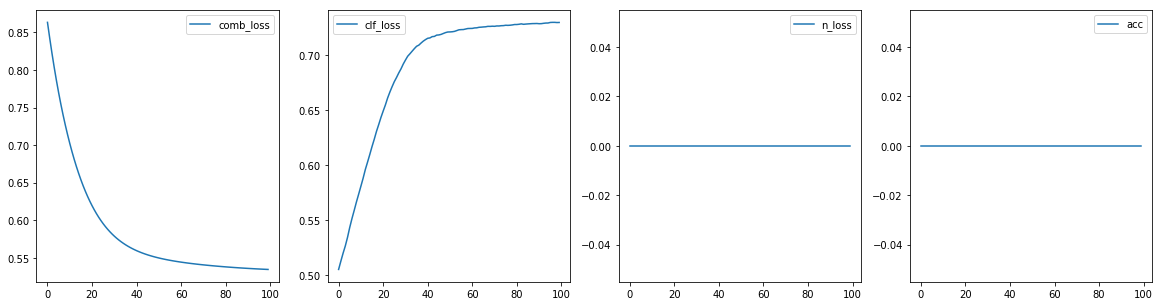

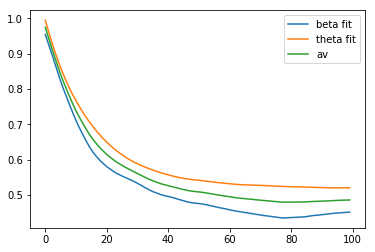

In [31]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

comb_loss, clf_loss, n_loss, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].plot(comb_loss, label="comb_loss")
axes[1].plot(clf_loss, label="clf_loss")
axes[2].plot(n_loss, label="n_loss")
axes[3].plot(acc, label="acc")

fig.set_size_inches(20, 5)
for i in [0,1,2,3]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [26]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 0.79123068  0.38420111]
 [ 3.56226209  2.72510324]
 [ 0.91482053  0.97297499]
 [ 1.90220212  0.3741329 ]
 [ 3.06992036  2.87189123]
 [ 1.09784711  2.62396533]
 [ 2.73909642  2.75038206]
 [ 0.92727076  0.41541096]
 [ 3.17409882  1.08940707]
 [ 3.40397174  0.73945254]
 [ 1.96328294  3.52886934]
 [ 1.219387    2.18579659]
 [ 1.46077015  1.18241372]
 [ 1.56017128  2.04926326]
 [ 1.9509898   3.2680642 ]
 [ 0.82146902  2.90232536]
 [ 2.38185914  0.00387951]
 [ 3.1017765   0.71648462]
 [ 1.50969148  1.25255397]
 [ 3.18909868  1.5653004 ]
 [ 2.96238764  1.6640633 ]
 [ 3.34527726  1.32454695]
 [ 2.1357172   0.90872437]
 [ 2.90544097  1.7383714 ]
 [ 0.61623571  2.47418263]
 [ 0.96057518  2.51552606]
 [ 2.43703967  3.10516385]
 [ 1.91382727  1.09328367]
 [ 1.57302606  1.34533051]
 [ 1.67148466  3.62864781]]
out [[ 0.9773894   0.        ]
 [ 3.45773816  2.84929895]
 [ 1.13628697  0.63637388]
 [ 1.84791625  0.54654533]
 [ 3.74400377  1.12691605]
 [ 0.40940946  2.93311024]
 [ 2.7753799   2.7

(30, 2) (30, 2)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


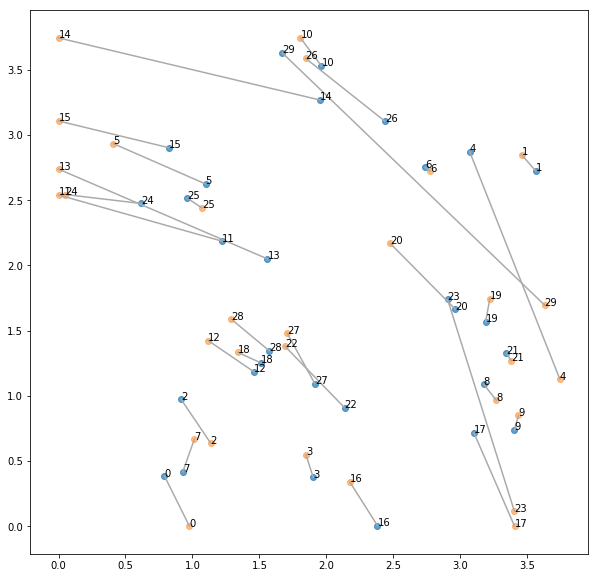

In [27]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca2 = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
print(itemz.shape,chosen.shape)
# itemz_2 = pca.fit_transform(itemz_2)
# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
#do not use by mistake # itemz_pred = pca2.fit_transform(itemz_pred)
# itemz_pred = pca.transform(itemz_pred)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")
    
fig.show()